### MPA_kNN

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Saving into Log

In [14]:
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("kNN_optimization_PTB_XL.log"),  # Log to this file
                        logging.StreamHandler()  # Log to standard output
                    ])

### Determining necessary parameters

In [15]:
import numpy as np

# Example usage with the correct bounds for SVM:
search_agents_no = 30  # number of search agents
dim = 2  # number of dimensions / hyperparameters
Max_iter = 20  # Maximum number of iterations

# Lower bounds for KNN parameters
n_neighbors_lb = 2
p_lb = 1

# Upper bounds for KNN parameters
n_neighbors_ub = 60
p_ub = 40

# Create arrays of lower bounds (lb) and upper bounds (ub) for KNN
lb = np.array([n_neighbors_lb, p_lb])
ub = np.array([n_neighbors_ub, p_ub])


### Loading Training Dataset

In [16]:
import cudf
import pandas as pd
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from cuml.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
train_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Train_new.csv')

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Split features and labels
X = train_data[features].astype('float32')  # Convert feature data to float32 for better performance
y = train_data[labels].astype('int32')  # Assuming target data are for classification and should be integers

# Convert to Pandas DataFrame for resampling
X_pd = X.to_pandas()
y_pd = y.to_pandas()

# Function to resample each label independently while aligning with the features
def resample_multilabel(X, y, labels):
    ros = RandomOverSampler(random_state=42)
    X_resampled = pd.DataFrame(X)  # Initialize X_resampled directly from the original X
    y_resampled = pd.DataFrame(index=X.index)  # Initialize y_resampled with the same index as X

    for label in labels:
        # Resample each label with the same features
        _, y_resampled[label] = ros.fit_resample(X, y[label])
        
    return X_resampled, y_resampled

# Apply resampling for multi-label data
X_resampled, y_resampled = resample_multilabel(X_pd, y_pd, labels)

# Convert back to cuDF DataFrames for further processing (if using cuML or other GPU-accelerated processes)
X_resampled = cudf.DataFrame.from_pandas(X_resampled)
y_resampled = cudf.DataFrame.from_pandas(y_resampled)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


### Levy, Initialization, Fitness and Confusion Matrix Plot Functions

In [17]:
import math

# Levy function
def levy(search_agents_no, dim, beta=3/2):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
            (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)) ** (1 / beta)
    u = np.random.randn(search_agents_no, dim) * sigma
    v = np.random.randn(search_agents_no, dim)
    step = u / (np.abs(v) ** (1 / beta))
    L = 0.05 * step  # Scale factor can be adjusted as needed
    return L

# Prey initialization function 
def initialization(search_agents_no, dim, ub, lb):
    if np.isscalar(lb) and np.isscalar(ub):
        # If the boundaries are both single numbers, apply them to all dimensions
        positions = np.random.rand(search_agents_no, dim) * (ub - lb) + lb
    else:
        # If the boundaries are arrays with different values for each dimension
        positions = np.zeros((search_agents_no, dim))
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            positions[:, i] = np.random.rand(search_agents_no) * (ub_i - lb_i) + lb_i
    return positions

# Objective fitness function
def kNN_accuracy_fitness(X_params, X_train, y_train, X_val, y_val):
    print("X_params shape:", X_params.shape)
    n_neighbors, p = int(round(X_params[0][0])), int(round(X_params[0][1]))
    print("n_neighbors:", n_neighbors, "p:", p)
    fitness_list = []
    conf_matrices = []
    
    # For multi-label classification, iterate over each label column and fit a separate classifier
    for label in labels:
        model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights='uniform')
        
        # Fit the model for the current label
        model.fit(X_train, y_train[label].astype('int32'))
        
        # Predict on validation set for the current label
        preds = model.predict(X_val).astype('int32')
        
        # Compute accuracy for the current label
        accuracy = accuracy_score(y_val[label].astype('int32'), preds)
        fitness_list.append(accuracy)
        
        # Compute confusion matrix for the current label
        conf_matrix = confusion_matrix(y_val[label].astype('int32'), preds)
        conf_matrix = conf_matrix.get()  # Convert from CuPy to NumPy if necessary
        conf_matrices.append(conf_matrix)
    
    # Calculate the average fitness across all labels
    fitness = np.mean(fitness_list)

    return fitness, conf_matrices



# Plot Confusion matrix function

def plot_confusion_matrix(conf_matrices, labels, individual_index):
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Adjust the figure size as necessary

    if num_labels == 1:  # If there's only one label, wrap axes in a list
        axes = [axes]

    for idx, (label, conf_matrix) in enumerate(zip(labels, conf_matrices)):
        ax = axes[idx]
        # Ensure the confusion matrix is in NumPy format
        if hasattr(conf_matrix, 'get'):  # Check if 'get' method exists, indicating a CuPy array
            conf_matrix = conf_matrix.get()  # Convert to NumPy array
        
        # Calculate percentage
        row_sums = conf_matrix.sum(axis=1, keepdims=True)
        percentage_matrix = 100 * conf_matrix / row_sums
        
        sns.heatmap(percentage_matrix, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=True)
        ax.set_title(label)  # Set the title to just the label name
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['False', 'True'])  # Assuming binary classification
        ax.set_yticklabels(['False', 'True'])

    # Set a title for the entire figure
    fig.suptitle(f"Confusion Matrix for Individual {individual_index}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for figure-wide title
    plt.show()


def get_model_from_params(params):
    n_neighbors, p = round(params[0]), round(params[1])
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors), p=int(p), weights='uniform')
    return model



### Define MPA function

In [18]:
import pickle


def MPA(search_agents_no, Max_iter, lb, ub, dim, X_train, y_train, X_val, y_val, kNN_accuracy_fitness, fitness_threshold=0.85):
   
    Top_predator_pos = np.zeros(dim)
    Top_predator_fit = -np.inf  # Start with the lowest possible value
    best_model = None  # Variable to store the best model
    stepsize = np.zeros((search_agents_no, dim))
    fitness = np.full(search_agents_no, -np.inf)
     
    Prey = initialization(search_agents_no, dim, ub, lb)
    model_path = 'best_model_mpa_kNN_ptb_xl.pkl'  # Define the path where the model will be saved

    Xmin = np.tile(lb, (search_agents_no, 1))
    Xmax = np.tile(ub, (search_agents_no, 1))

    best_fitness_values = []  # Keep track of the best fitness value at each iteration
    average_fitness_values = []  # Keep track of the average fitness value
    
    Iter = 0
    FADs = 0.2
    P = 0.5

    for Iter in range(Max_iter):
        # Detecting Top predator
        for i in range(search_agents_no):
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = Prey[i, :] * (~(Flag4ub | Flag4lb)) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual {i+1}/{search_agents_no}")
            fitness[i], conf_matrices = kNN_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
        # Marine memory saving
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        # For maximization: Check if the current fitness is greater than the old fitness
        Inx = fitness > fit_old
        Indx = np.tile(Inx[:, None], (1, dim))
        
        # Update positions: Use the newer positions if the current fitness is better; otherwise, revert to old positions
        Prey = Indx * Prey + (~Indx) * Prey_old
        
        # Update fitness: Keep the higher current fitness values; otherwise, revert to old fitness values
        fitness = np.where(Inx, fitness, fit_old)
        
        fit_old = fitness.copy()  # Prepare for the next iteration
        Prey_old = Prey.copy()

        # --------------------////------------------
        Elite = np.tile(Top_predator_pos, (search_agents_no, 1))  # Construct Elite Matrix
        CF = (1 - Iter / Max_iter) ** (2 * Iter / Max_iter)

        RL = 0.05 * levy(search_agents_no, dim, 1.5)    # Levy random number vector
        RB = np.random.randn(search_agents_no, dim)     # Brownian random number vector

        for i in range(search_agents_no):
            for j in range(dim):
                R = np.random.rand()
                # Phase 1
                if Iter < Max_iter / 3:
                    stepsize[i, j] = RB[i, j] * (Elite[i, j] - RB[i, j] * Prey[i, j])
                    Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 2
                elif Max_iter / 3 < Iter < 2 * Max_iter / 3:
                    if i > search_agents_no / 2:
                        stepsize[i, j] = RB[i, j] * (RB[i, j] * Elite[i, j] - Prey[i, j])
                        Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                    else:
                        stepsize[i, j] = RL[i, j] * (Elite[i, j] - RL[i, j] * Prey[i, j])
                        Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 3
                else:
                    stepsize[i, j] = RL[i, j] * (RL[i, j] * Elite[i, j] - Prey[i, j])
                    Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                # ------------------ Detecting top predator ------------------  
        for i in range(search_agents_no):
            # Enforce boundary conditions
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = (Prey[i, :] * (~(Flag4ub | Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual after 3 Phases {i+1}/{search_agents_no}")
            # Evaluate fitness
            fitness[i], conf_matrices = kNN_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            # Update top predator if current solution is better (for maximization)
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
        # Marine memory saving  --------///-----------
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        Inx = fitness > fit_old  # For maximization: keep if current fitness is better
        Indx = np.tile(Inx[:, None], (1, dim))
        Prey = Indx * Prey + (~Indx) * Prey_old  # Update positions based on better fitness
        fitness = np.where(Inx, fitness, fit_old)  # Update fitness values accordingly
        
        fit_old = fitness.copy()  # Update old fitness for the next iteration
        Prey_old = Prey.copy()  # Update old positions for the next iteration
        
        
        # Eddy formation and FADs’ effect
        if np.random.rand() < FADs:
            U = np.random.rand(search_agents_no, dim) < FADs
            Prey = Prey + CF * ((Xmin + np.random.rand(search_agents_no, dim) * (Xmax - Xmin)) * U)
        else:
            r = np.random.rand()
            Rs = Prey.shape[0]
            stepsize = (FADs * (1 - r) + r) * (Prey[np.random.permutation(Rs), :] - Prey[np.random.permutation(Rs), :])
            Prey = Prey + stepsize

        current_best_fitness = Top_predator_fit
        best_fitness_values.append(current_best_fitness)
        
        # Calculate average fitness of the population
        current_avg_fitness = np.mean(fitness)
        average_fitness_values.append(current_avg_fitness)
        
        # Log the metrics
        logging.info(f"Iteration: {Iter+1}/{Max_iter}, Best Fitness: {current_best_fitness}, Average Fitness: {current_avg_fitness}")
        
        if Top_predator_fit >= fitness_threshold:
            logging.info(f"Fitness threshold reached: {Top_predator_fit} at iteration {Iter+1}. Terminating...")
            with open(model_path, 'wb') as f:
                pickle.dump(best_model, f)  # Save the best model
            logging.info(f"Model saved to {model_path} with fitness {Top_predator_fit} at iteration {Iter+1}")
            break  # Exit the loop if fitness threshold is reached
        
        # Update iteration counter and convergence curve
        Iter += 1

    return Top_predator_pos, Top_predator_fit


### Call MPA

2024-04-16 03:59:07,409 - INFO - Calculating fitness for individual 1/30


X_params shape: (1, 2)
n_neighbors: 2 p: 1


2024-04-16 03:59:13,135 - INFO - Fitness for individual 1: 0.8964573025703431


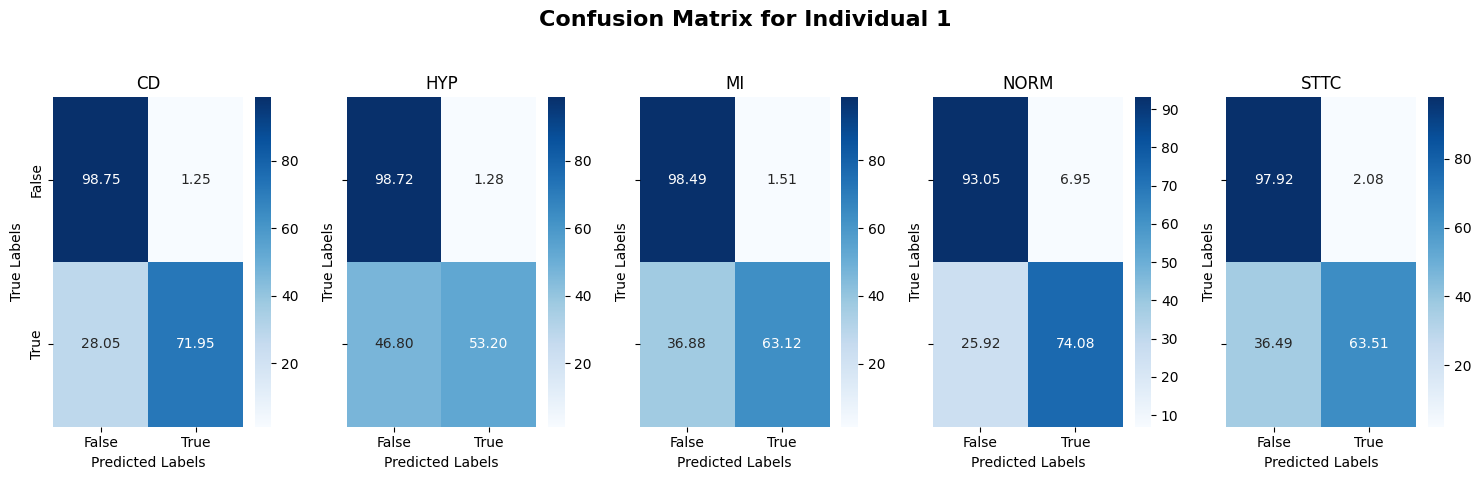

2024-04-16 03:59:15,322 - INFO - Calculating fitness for individual 2/30


X_params shape: (1, 2)
n_neighbors: 45 p: 31


2024-04-16 03:59:22,121 - INFO - Fitness for individual 2: 0.8278460264205932


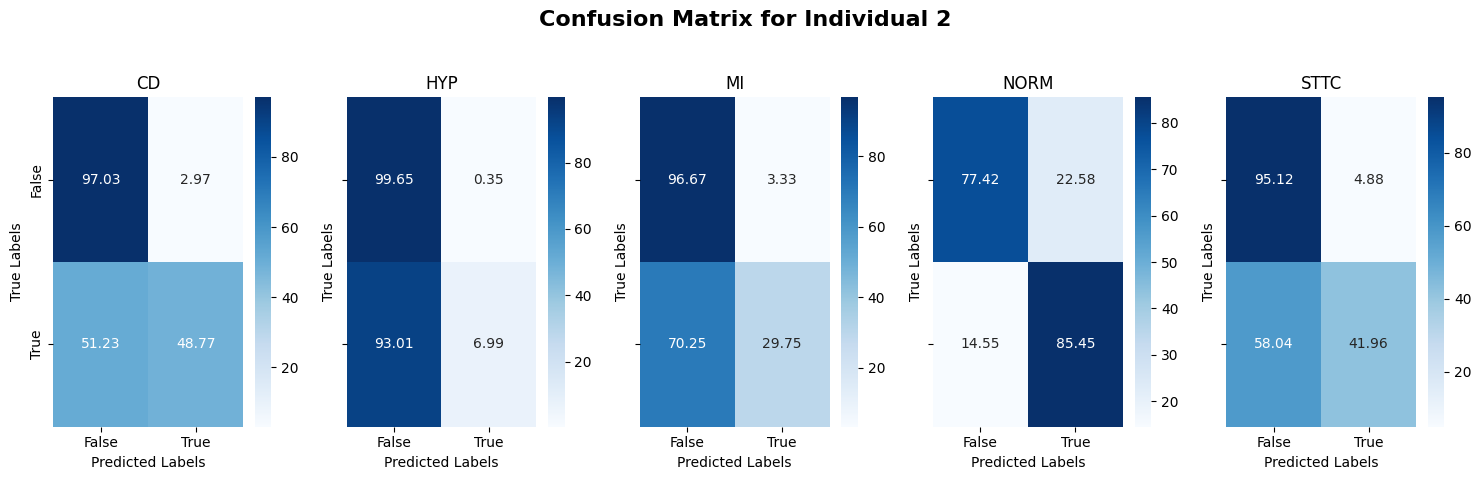

2024-04-16 03:59:23,925 - INFO - Calculating fitness for individual 3/30


X_params shape: (1, 2)
n_neighbors: 34 p: 27


2024-04-16 03:59:30,723 - INFO - Fitness for individual 3: 0.8324487209320068


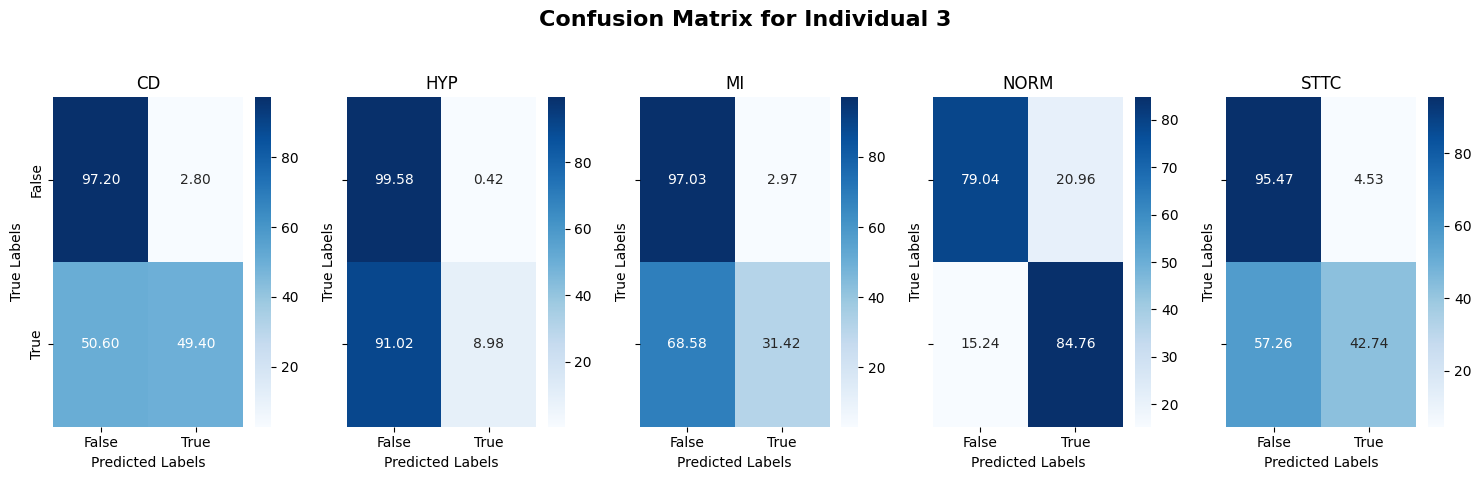

2024-04-16 03:59:32,540 - INFO - Calculating fitness for individual 4/30


X_params shape: (1, 2)
n_neighbors: 48 p: 1


2024-04-16 03:59:39,351 - INFO - Fitness for individual 4: 0.8257158041000366


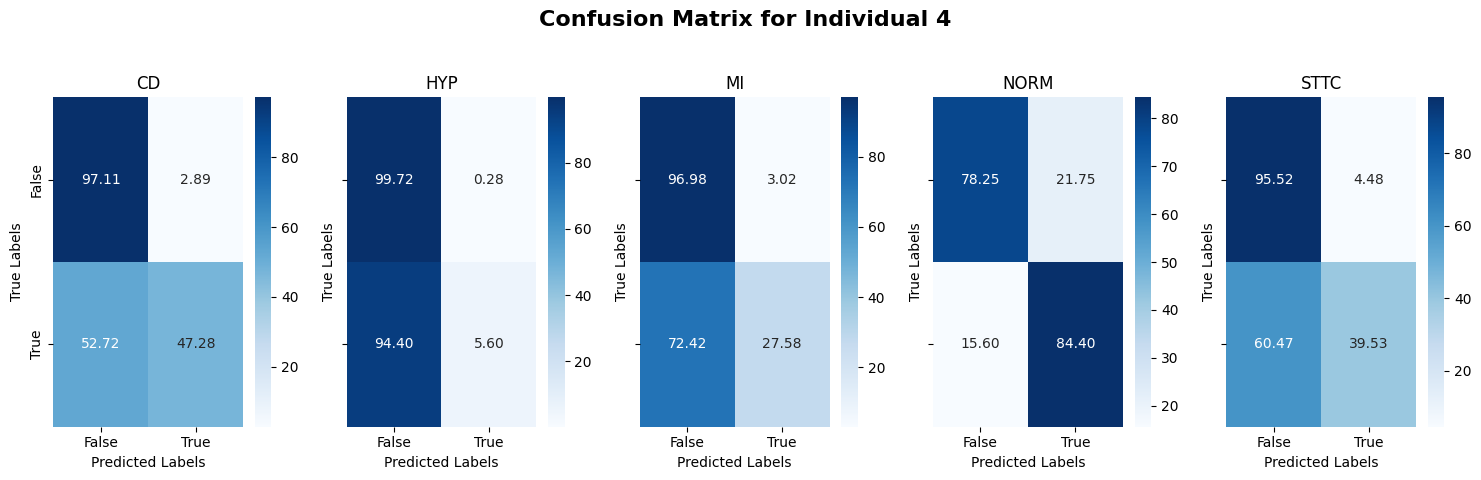

2024-04-16 03:59:41,151 - INFO - Calculating fitness for individual 5/30


X_params shape: (1, 2)
n_neighbors: 46 p: 19


2024-04-16 03:59:47,864 - INFO - Fitness for individual 5: 0.8264974117279053


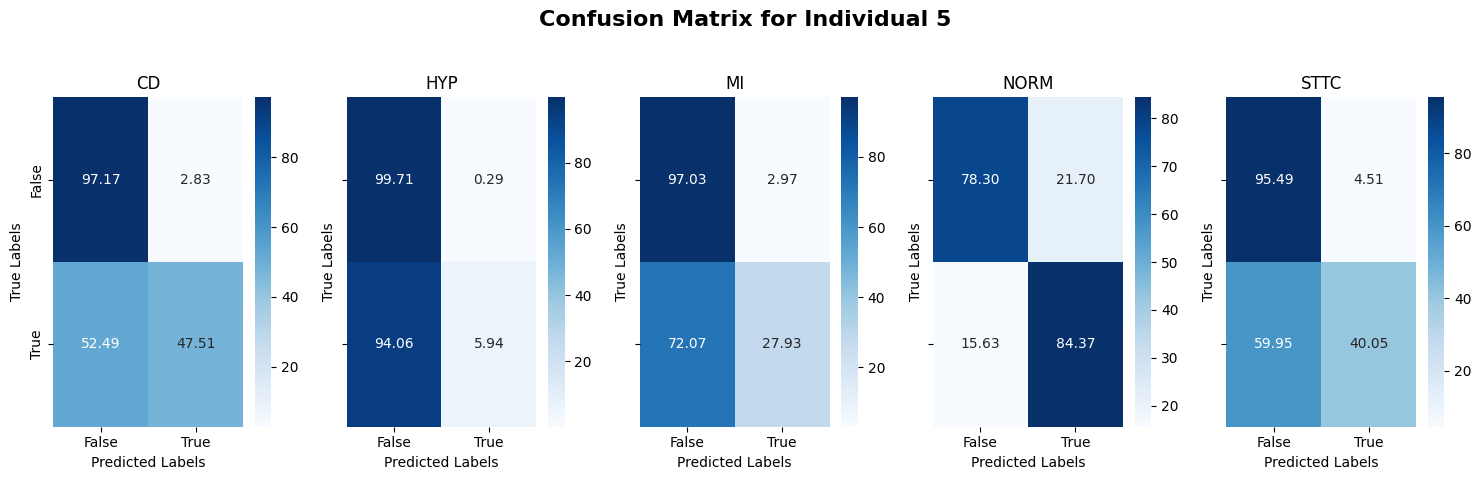

2024-04-16 03:59:49,957 - INFO - Calculating fitness for individual 6/30


X_params shape: (1, 2)
n_neighbors: 2 p: 23


2024-04-16 03:59:55,892 - INFO - Fitness for individual 6: 0.8964573025703431


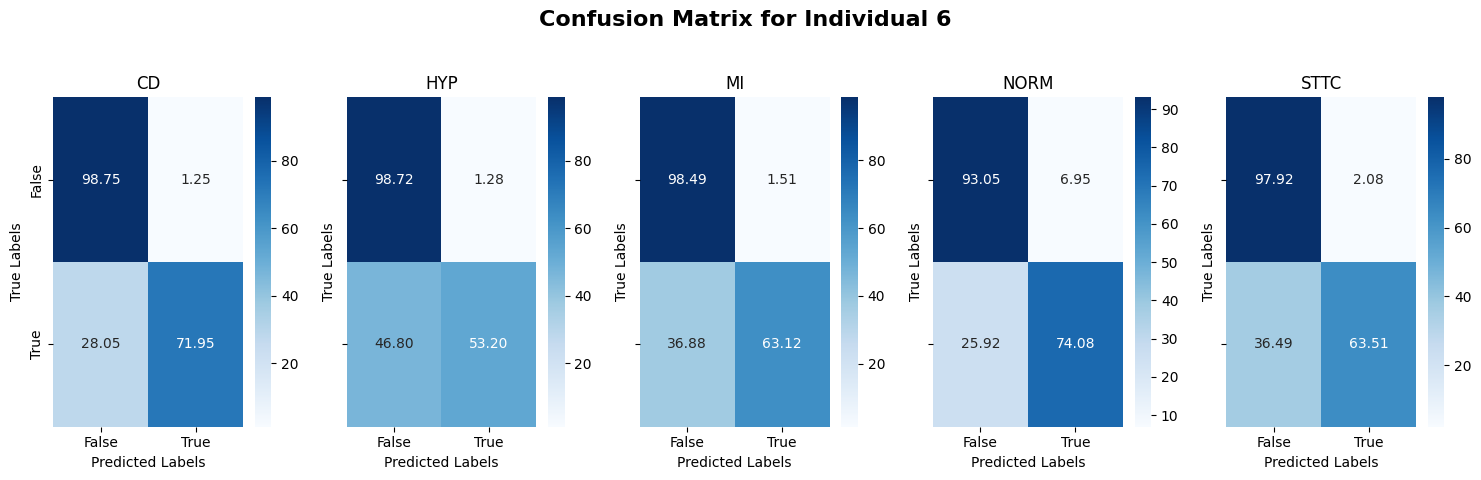

2024-04-16 03:59:57,715 - INFO - Calculating fitness for individual 7/30


X_params shape: (1, 2)
n_neighbors: 3 p: 20


2024-04-16 04:00:03,485 - INFO - Fitness for individual 7: 0.8978008270263672


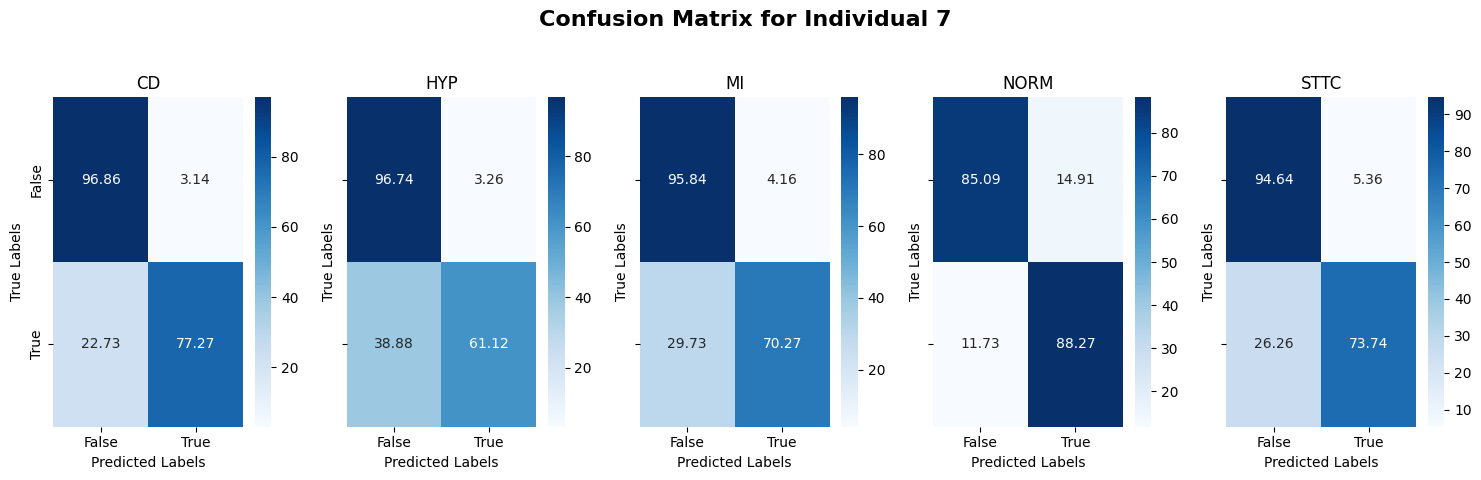

2024-04-16 04:00:05,348 - INFO - Calculating fitness for individual 8/30


X_params shape: (1, 2)
n_neighbors: 2 p: 22


2024-04-16 04:00:11,089 - INFO - Fitness for individual 8: 0.8964573025703431


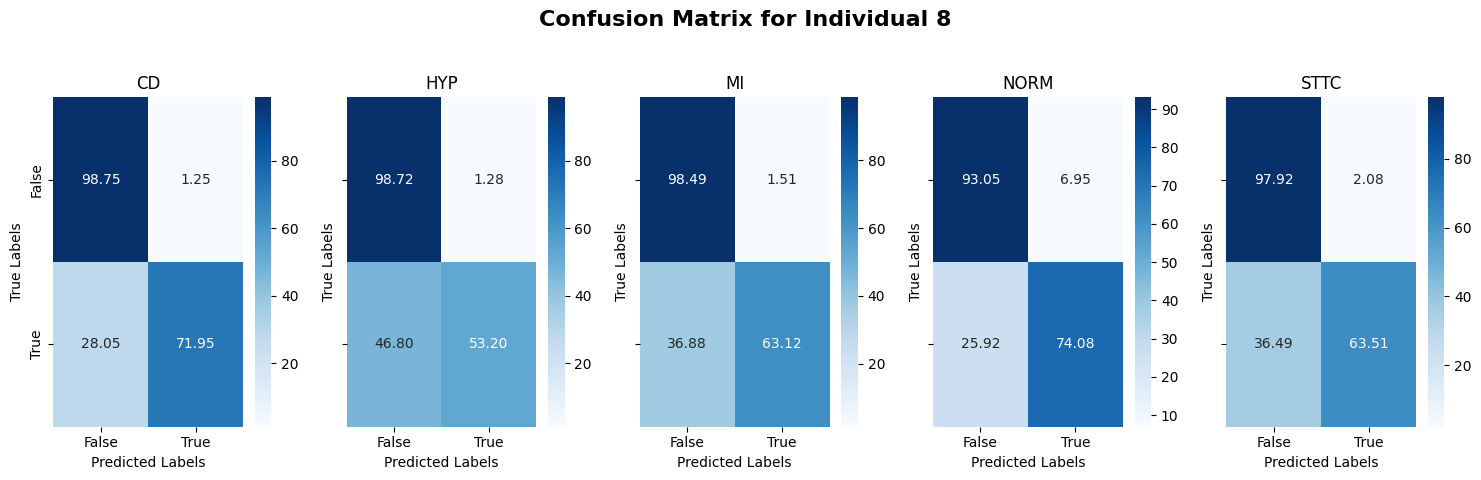

2024-04-16 04:00:12,931 - INFO - Calculating fitness for individual 9/30


X_params shape: (1, 2)
n_neighbors: 18 p: 27


2024-04-16 04:00:18,847 - INFO - Fitness for individual 9: 0.8495313048362731


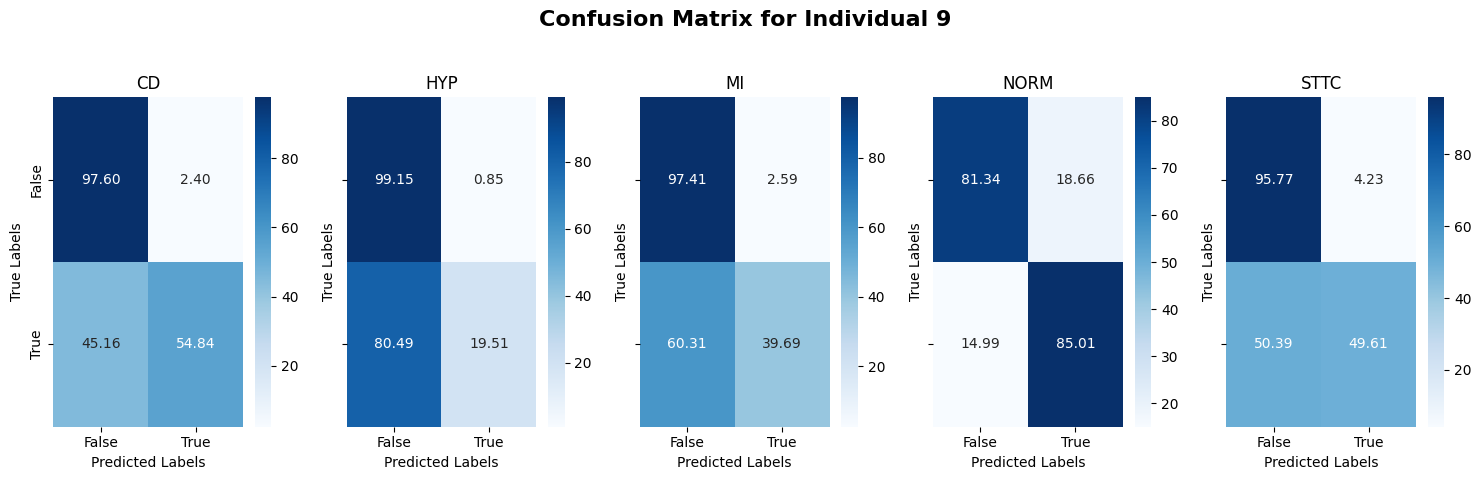

2024-04-16 04:00:20,702 - INFO - Calculating fitness for individual 10/30


X_params shape: (1, 2)
n_neighbors: 35 p: 23


2024-04-16 04:00:27,461 - INFO - Fitness for individual 10: 0.8329493522644043


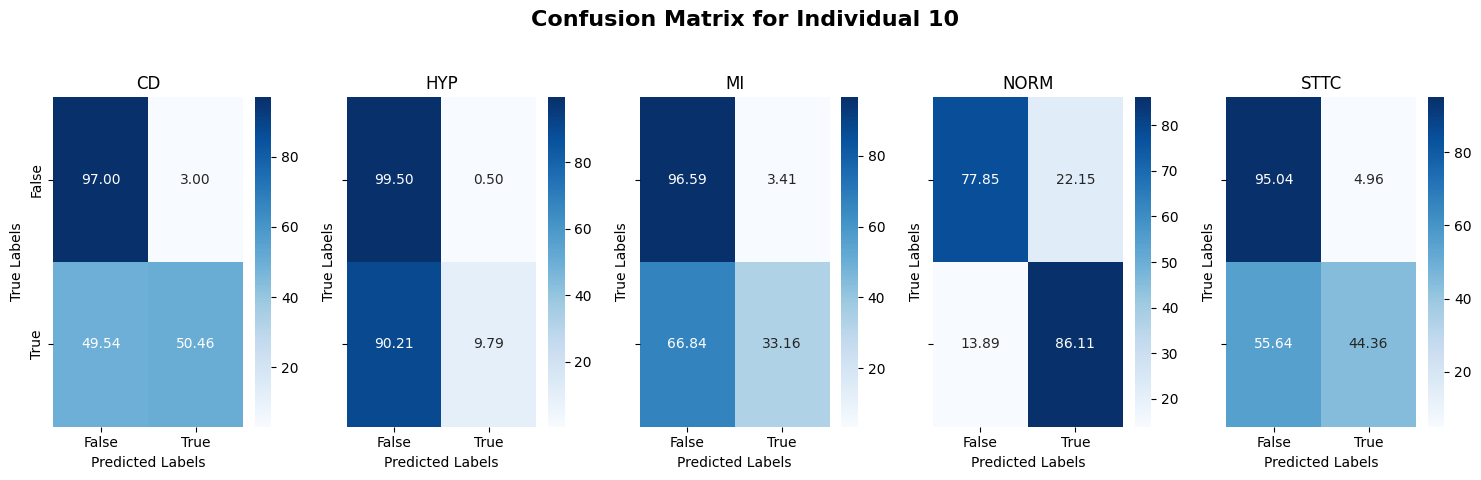

2024-04-16 04:00:29,651 - INFO - Calculating fitness for individual 11/30


X_params shape: (1, 2)
n_neighbors: 29 p: 16


2024-04-16 04:00:35,529 - INFO - Fitness for individual 11: 0.8374345660209656


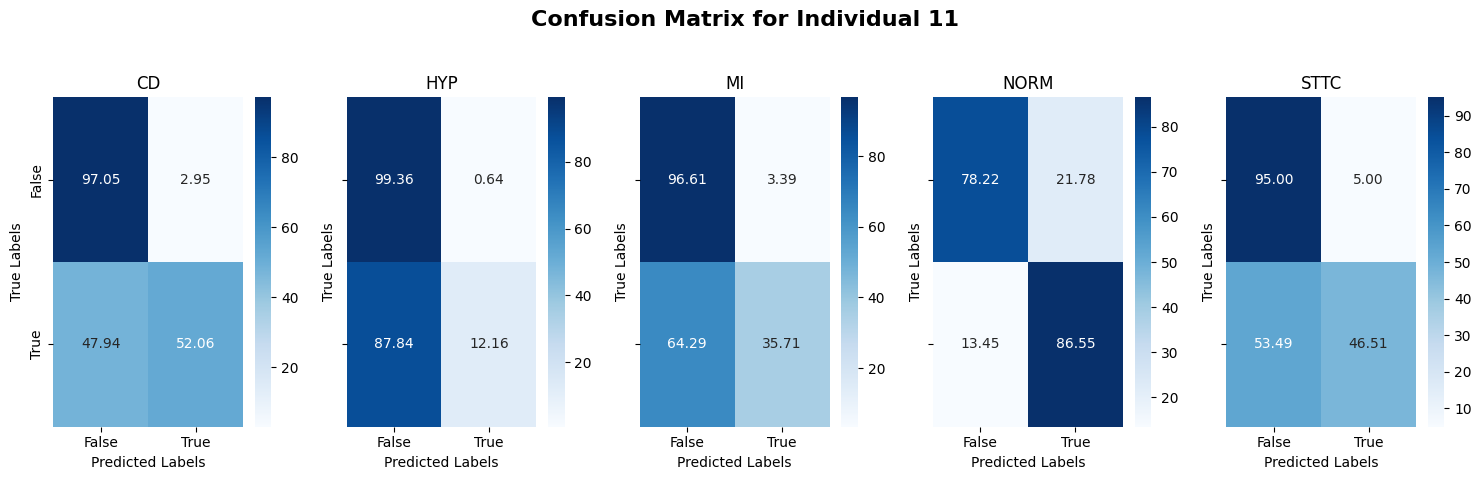

2024-04-16 04:00:37,376 - INFO - Calculating fitness for individual 12/30


X_params shape: (1, 2)
n_neighbors: 24 p: 12


2024-04-16 04:00:43,275 - INFO - Fitness for individual 12: 0.8407907843589782


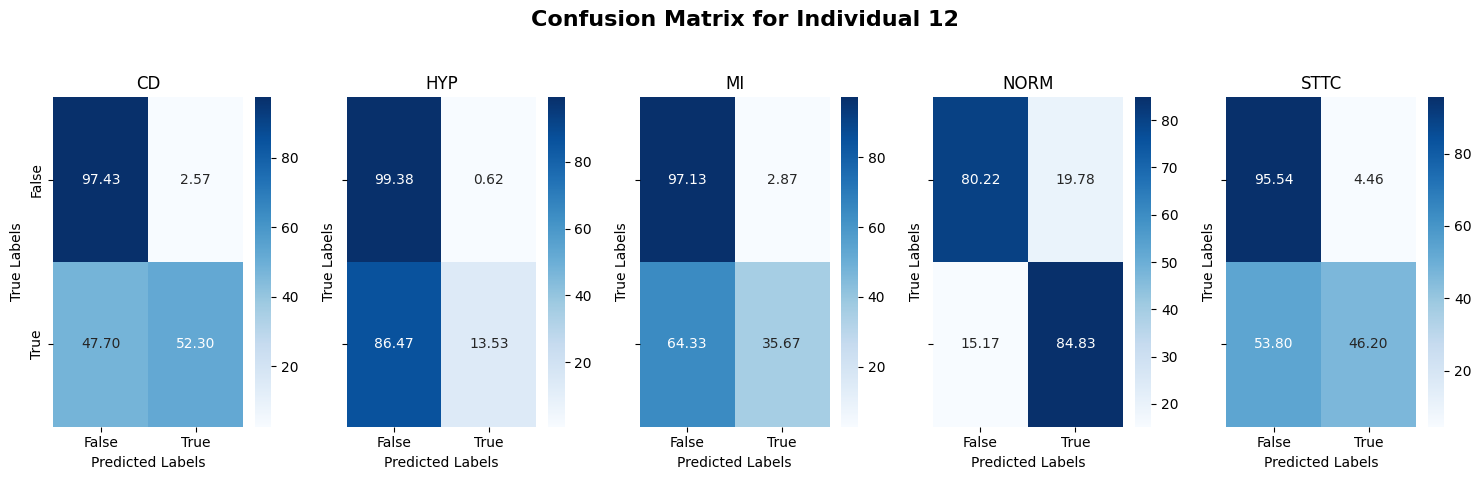

2024-04-16 04:00:45,069 - INFO - Calculating fitness for individual 13/30


X_params shape: (1, 2)
n_neighbors: 37 p: 39


2024-04-16 04:00:51,670 - INFO - Fitness for individual 13: 0.8317590951919556


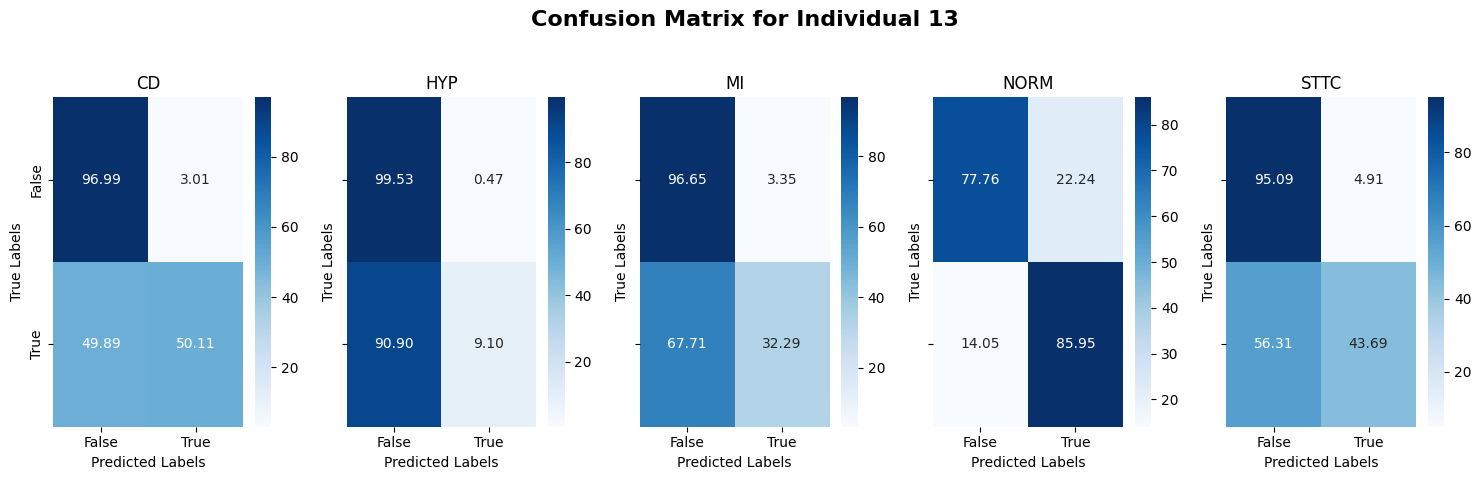

2024-04-16 04:00:53,480 - INFO - Calculating fitness for individual 14/30


X_params shape: (1, 2)
n_neighbors: 40 p: 15


2024-04-16 04:01:00,269 - INFO - Fitness for individual 14: 0.829179322719574


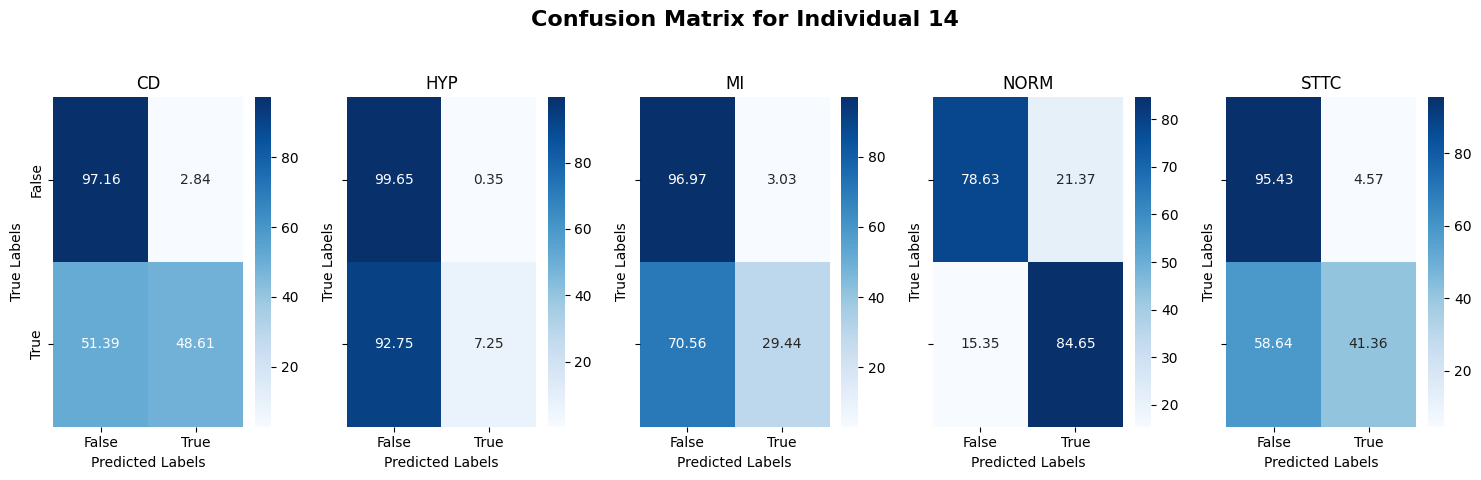

2024-04-16 04:01:02,065 - INFO - Calculating fitness for individual 15/30


X_params shape: (1, 2)
n_neighbors: 29 p: 27


2024-04-16 04:01:08,022 - INFO - Fitness for individual 15: 0.8374345660209656


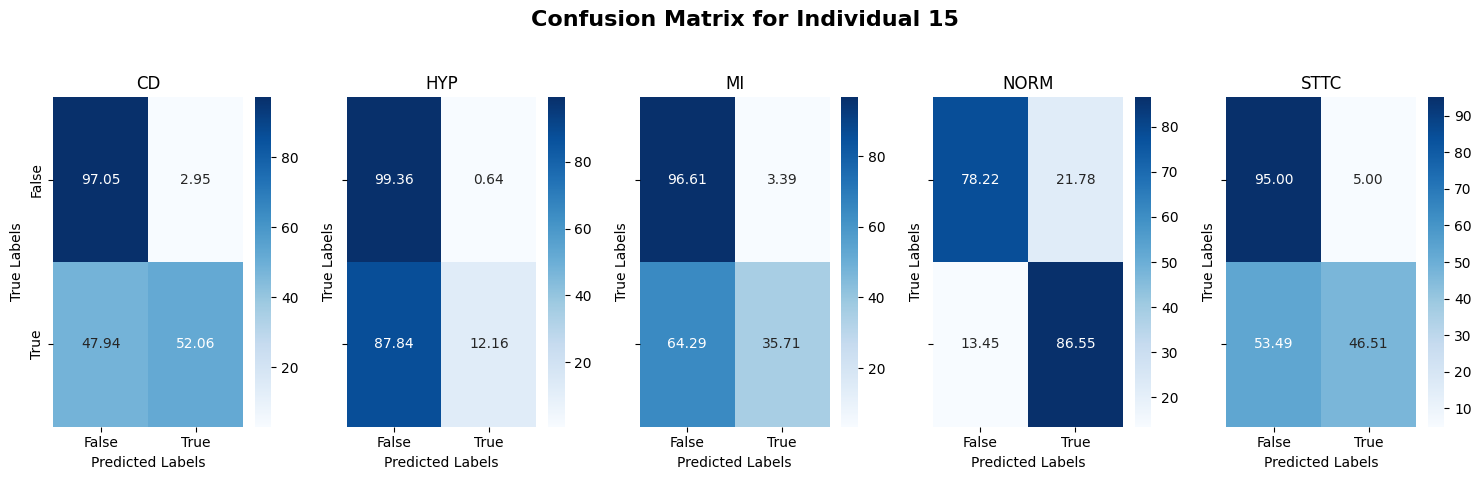

2024-04-16 04:01:10,176 - INFO - Calculating fitness for individual 16/30


X_params shape: (1, 2)
n_neighbors: 13 p: 31


2024-04-16 04:01:16,065 - INFO - Fitness for individual 16: 0.8618783593177796


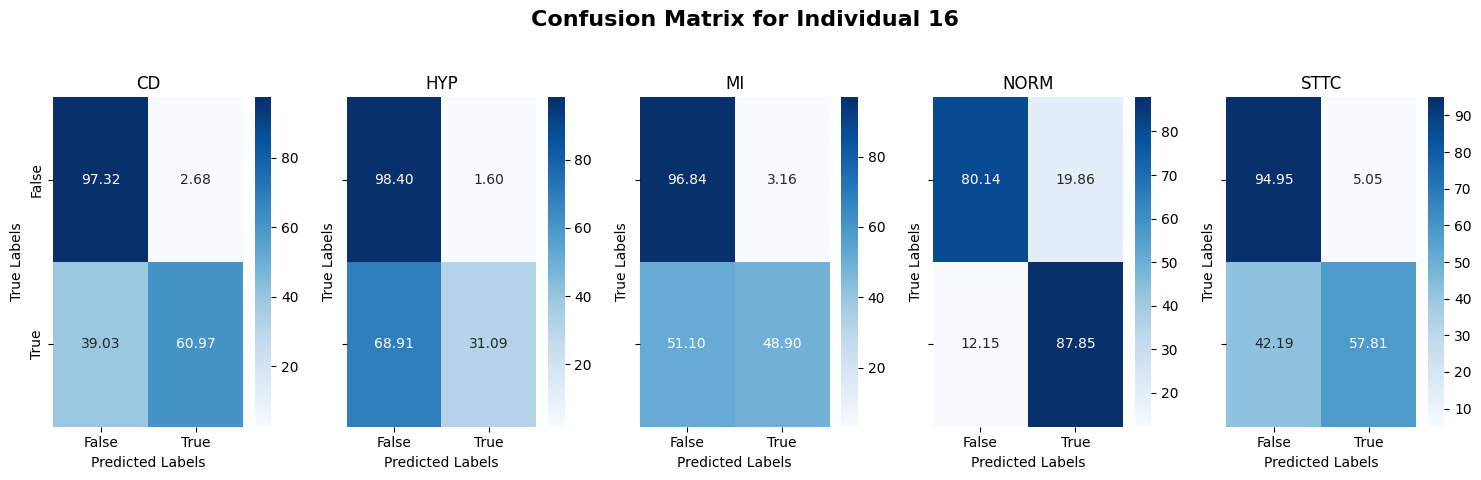

2024-04-16 04:01:17,912 - INFO - Calculating fitness for individual 17/30


X_params shape: (1, 2)
n_neighbors: 12 p: 17


2024-04-16 04:01:23,935 - INFO - Fitness for individual 17: 0.8615718603134155


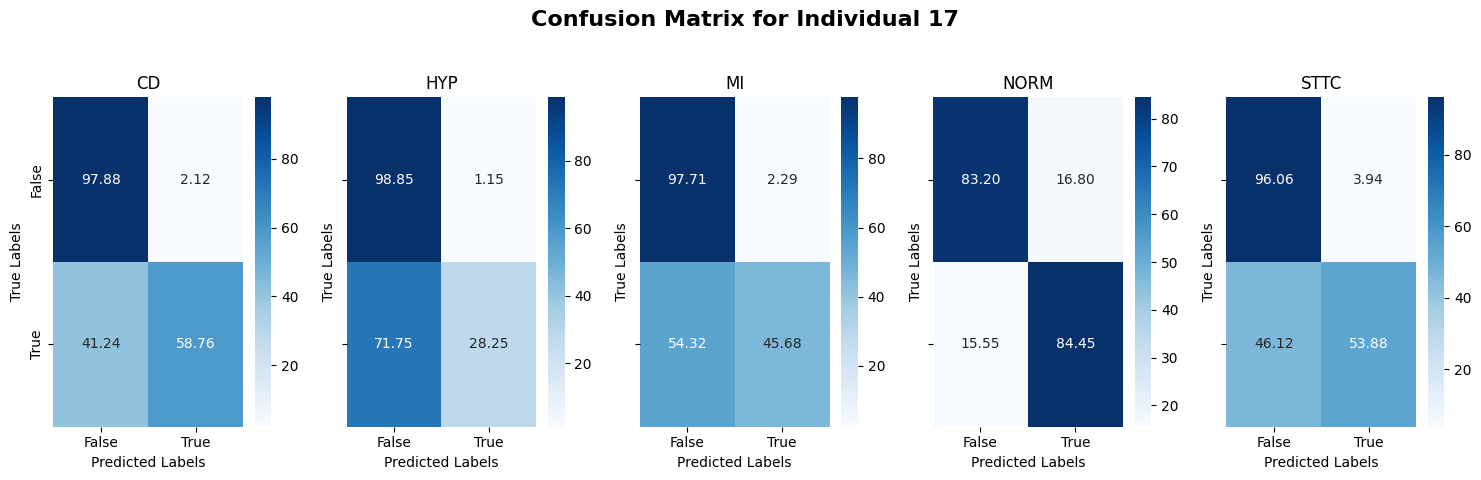

2024-04-16 04:01:25,737 - INFO - Calculating fitness for individual 18/30


X_params shape: (1, 2)
n_neighbors: 48 p: 38


2024-04-16 04:01:32,434 - INFO - Fitness for individual 18: 0.8257158041000366


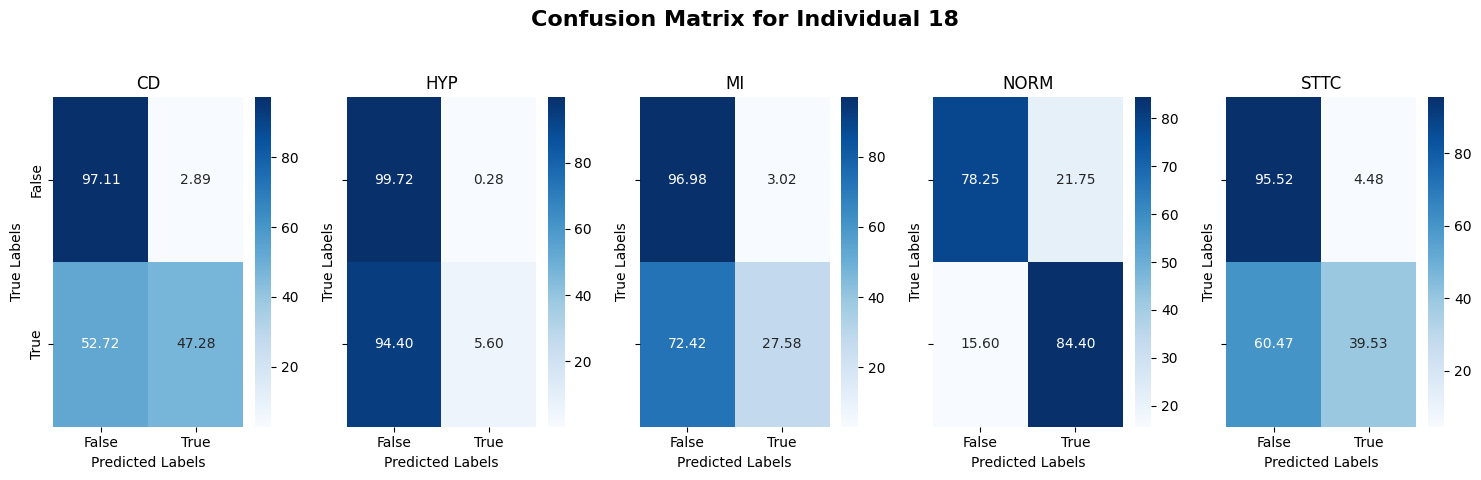

2024-04-16 04:01:34,245 - INFO - Calculating fitness for individual 19/30


X_params shape: (1, 2)
n_neighbors: 19 p: 35


2024-04-16 04:01:40,157 - INFO - Fitness for individual 19: 0.849761176109314


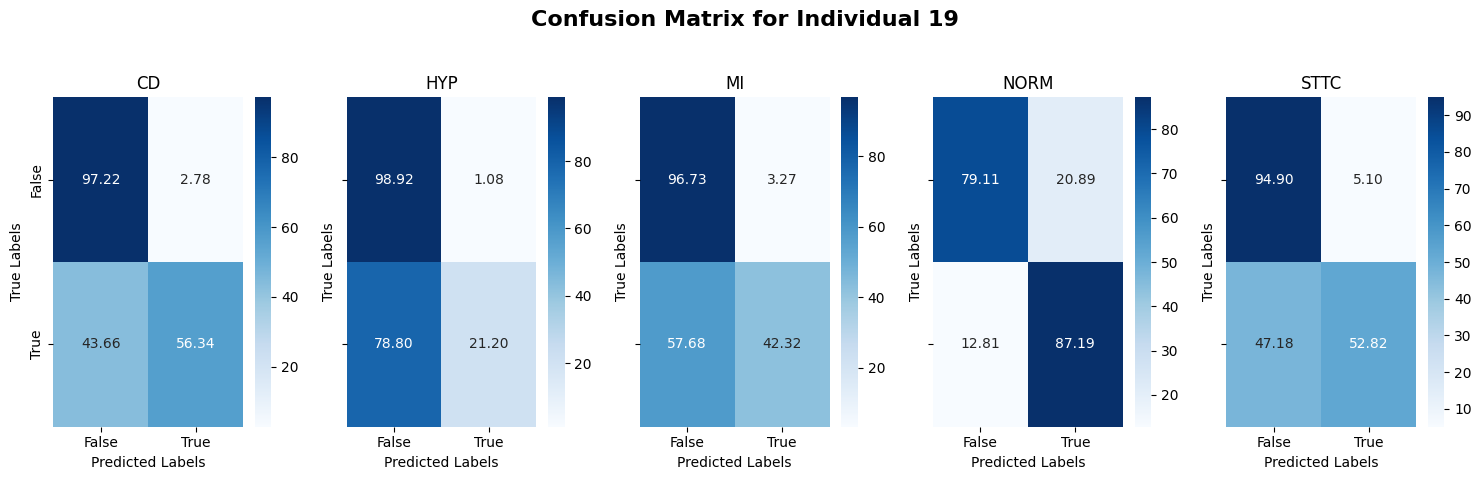

2024-04-16 04:01:41,998 - INFO - Calculating fitness for individual 20/30


X_params shape: (1, 2)
n_neighbors: 52 p: 15


2024-04-16 04:01:48,757 - INFO - Fitness for individual 20: 0.8241526365280152


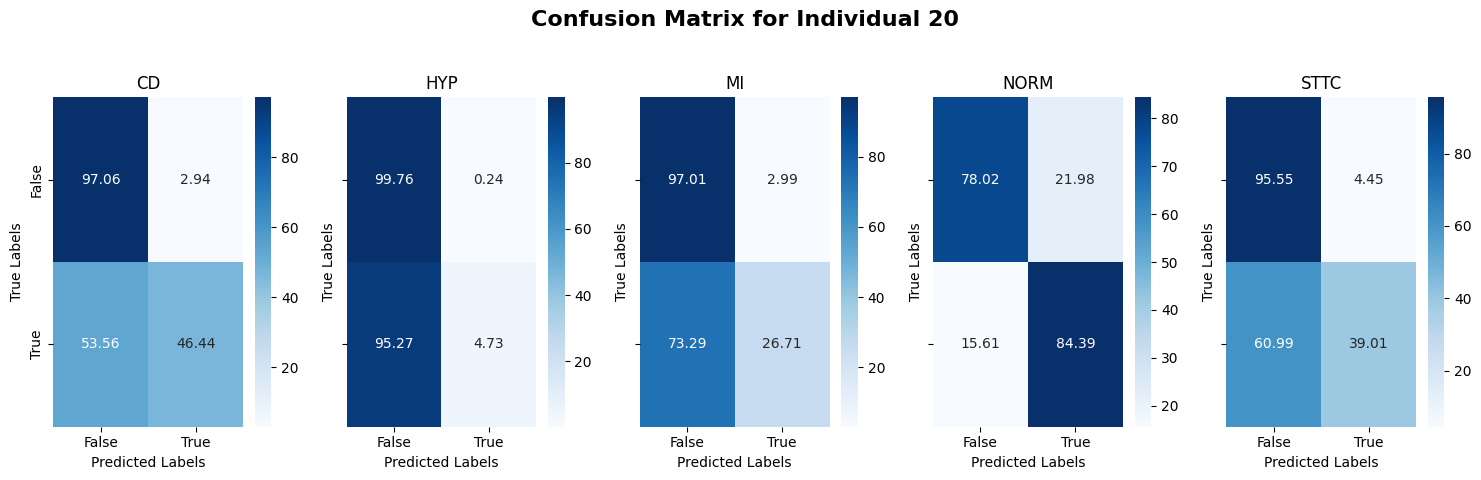

2024-04-16 04:01:50,873 - INFO - Calculating fitness for individual 21/30


X_params shape: (1, 2)
n_neighbors: 12 p: 40


2024-04-16 04:01:56,969 - INFO - Fitness for individual 21: 0.8615718603134155


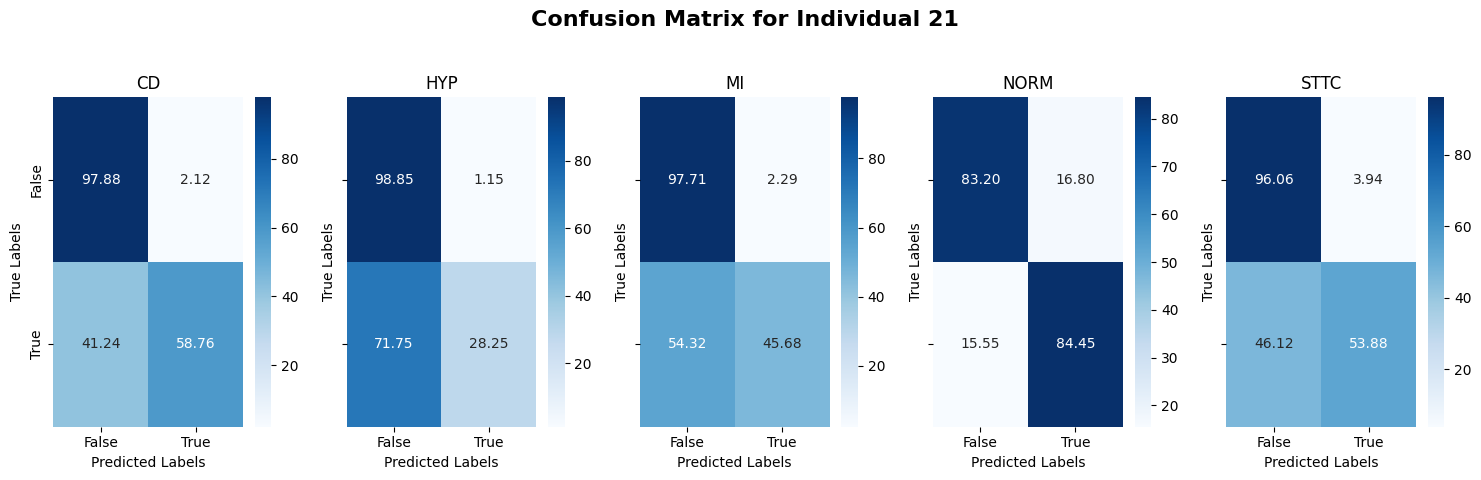

2024-04-16 04:01:58,780 - INFO - Calculating fitness for individual 22/30


X_params shape: (1, 2)
n_neighbors: 10 p: 4


2024-04-16 04:02:04,625 - INFO - Fitness for individual 22: 0.866910171508789


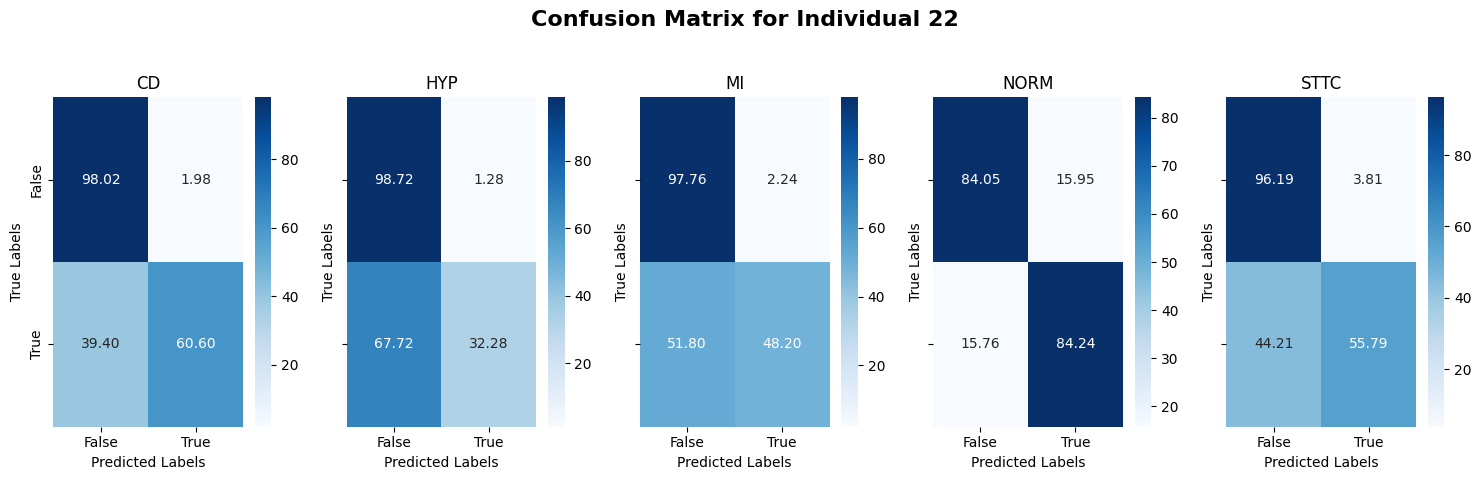

2024-04-16 04:02:06,431 - INFO - Calculating fitness for individual 23/30


X_params shape: (1, 2)
n_neighbors: 35 p: 14


2024-04-16 04:02:13,194 - INFO - Fitness for individual 23: 0.8329493522644043


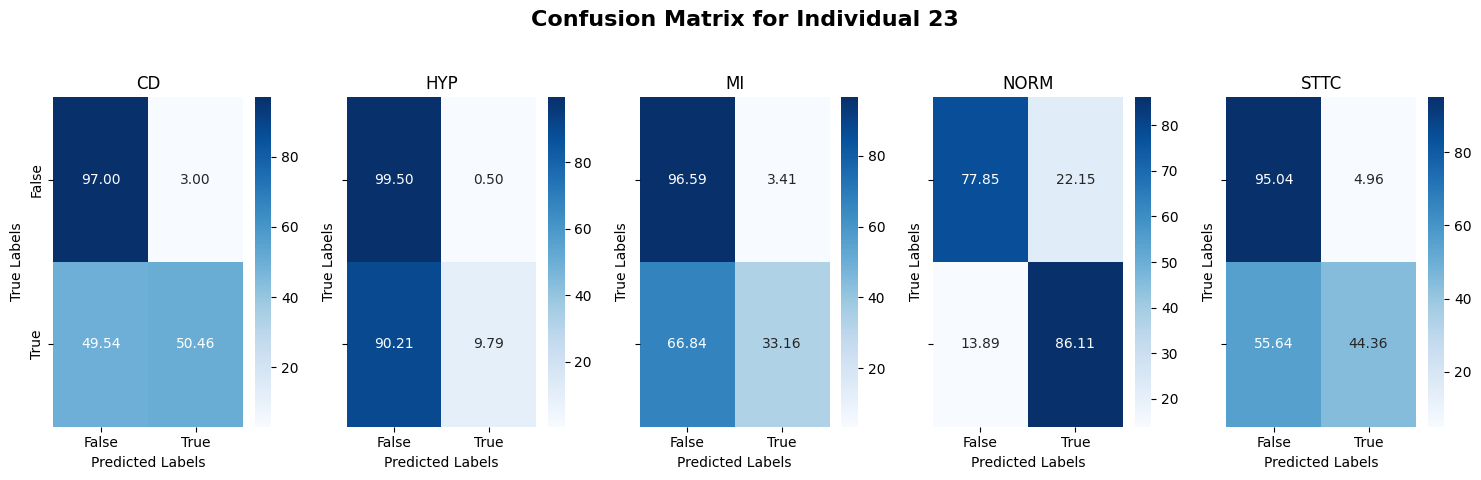

2024-04-16 04:02:14,994 - INFO - Calculating fitness for individual 24/30


X_params shape: (1, 2)
n_neighbors: 42 p: 5


2024-04-16 04:02:21,759 - INFO - Fitness for individual 24: 0.8279890656471253


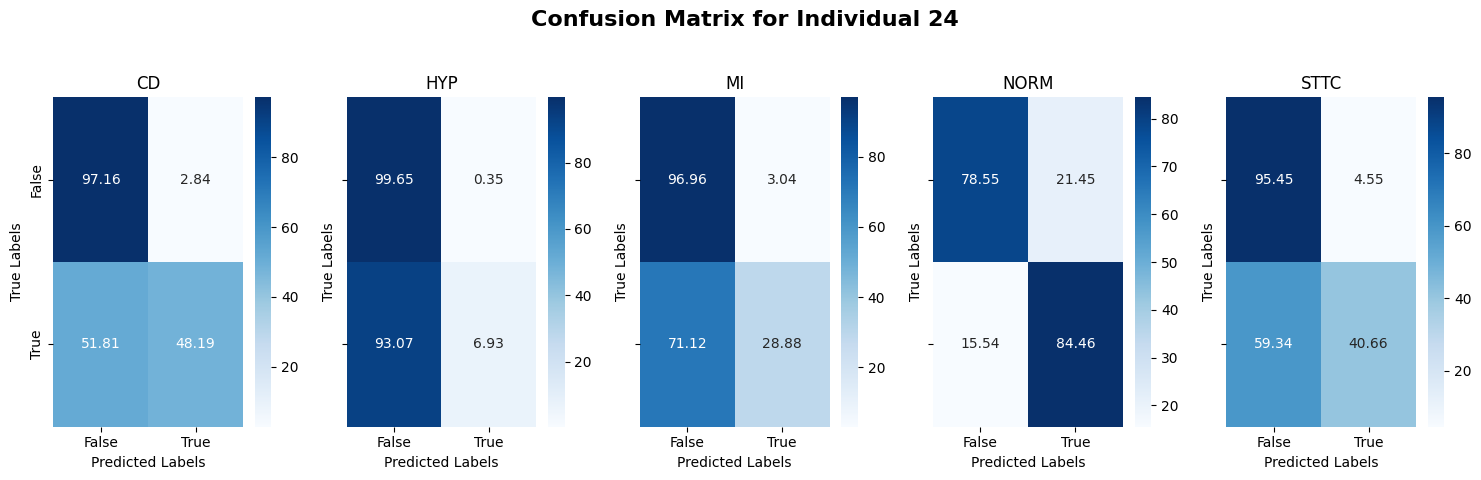

2024-04-16 04:02:23,570 - INFO - Calculating fitness for individual 25/30


X_params shape: (1, 2)
n_neighbors: 7 p: 12


2024-04-16 04:02:29,393 - INFO - Fitness for individual 25: 0.8791601777076721


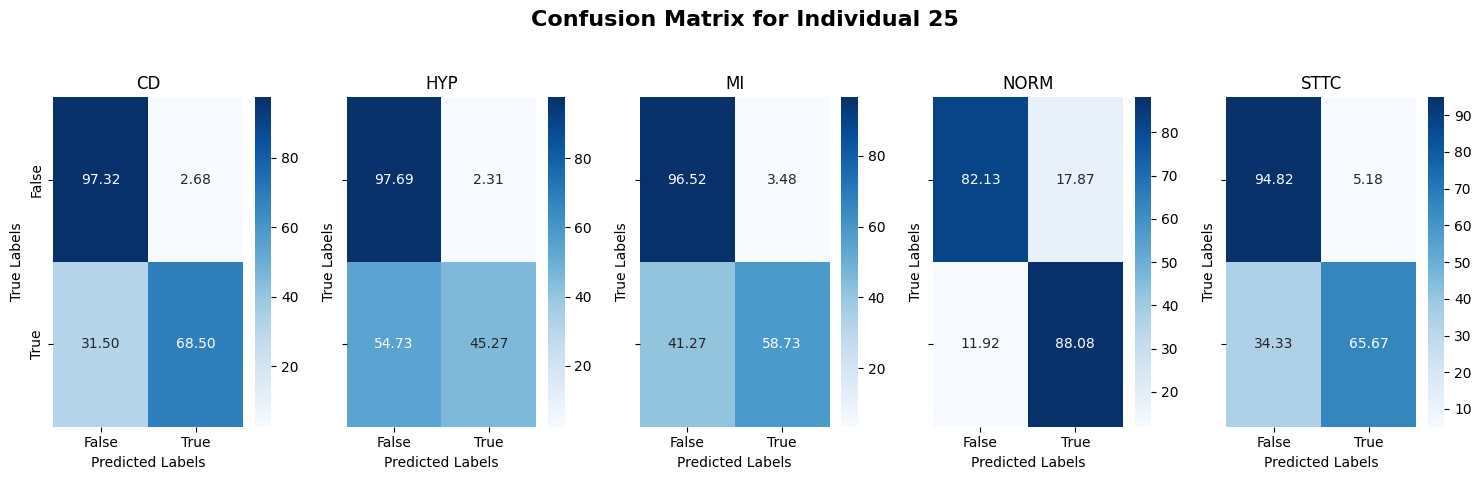

2024-04-16 04:02:31,559 - INFO - Calculating fitness for individual 26/30


X_params shape: (1, 2)
n_neighbors: 52 p: 8


2024-04-16 04:02:38,363 - INFO - Fitness for individual 26: 0.8241526365280152


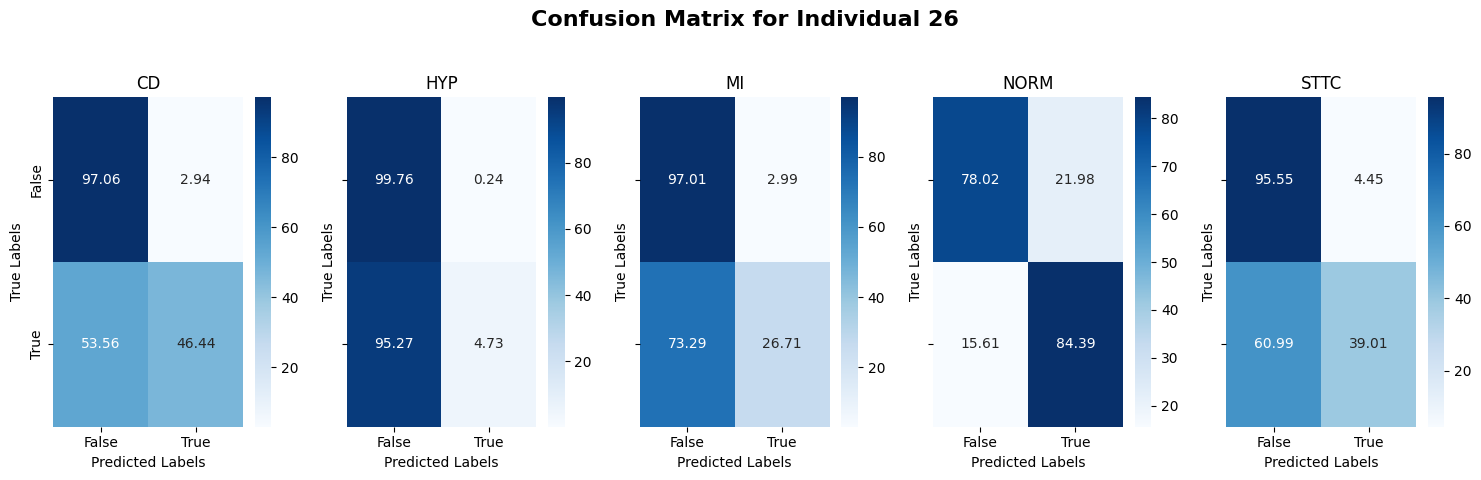

2024-04-16 04:02:40,163 - INFO - Calculating fitness for individual 27/30


X_params shape: (1, 2)
n_neighbors: 5 p: 39


2024-04-16 04:02:46,216 - INFO - Fitness for individual 27: 0.887165081501007


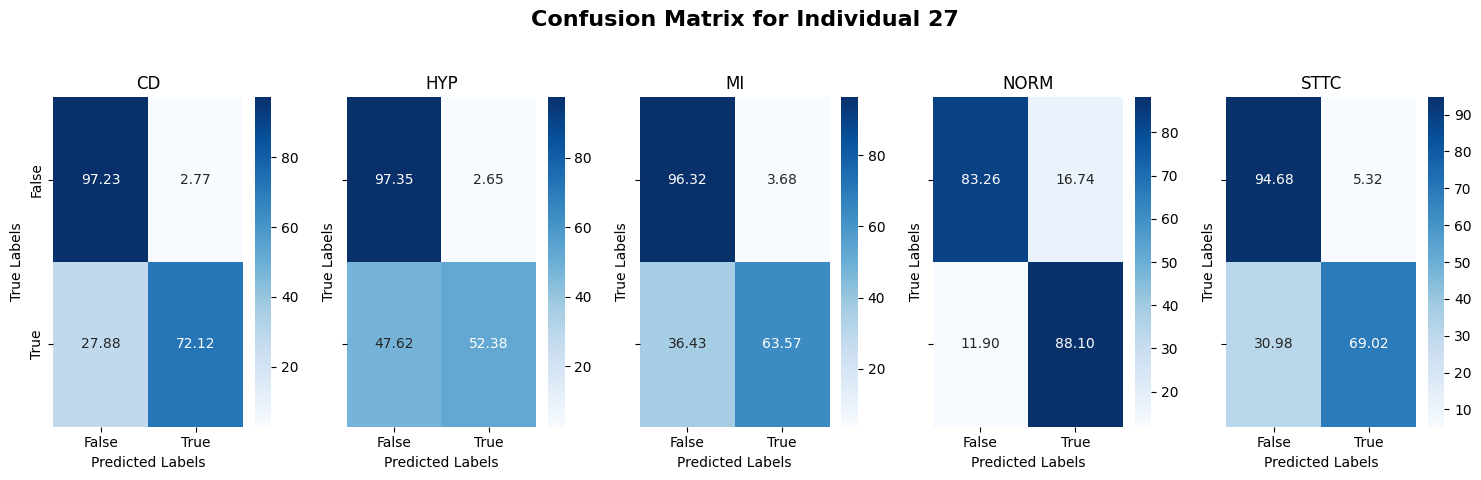

2024-04-16 04:02:48,087 - INFO - Calculating fitness for individual 28/30


X_params shape: (1, 2)
n_neighbors: 33 p: 25


2024-04-16 04:02:54,795 - INFO - Fitness for individual 28: 0.8340834140777588


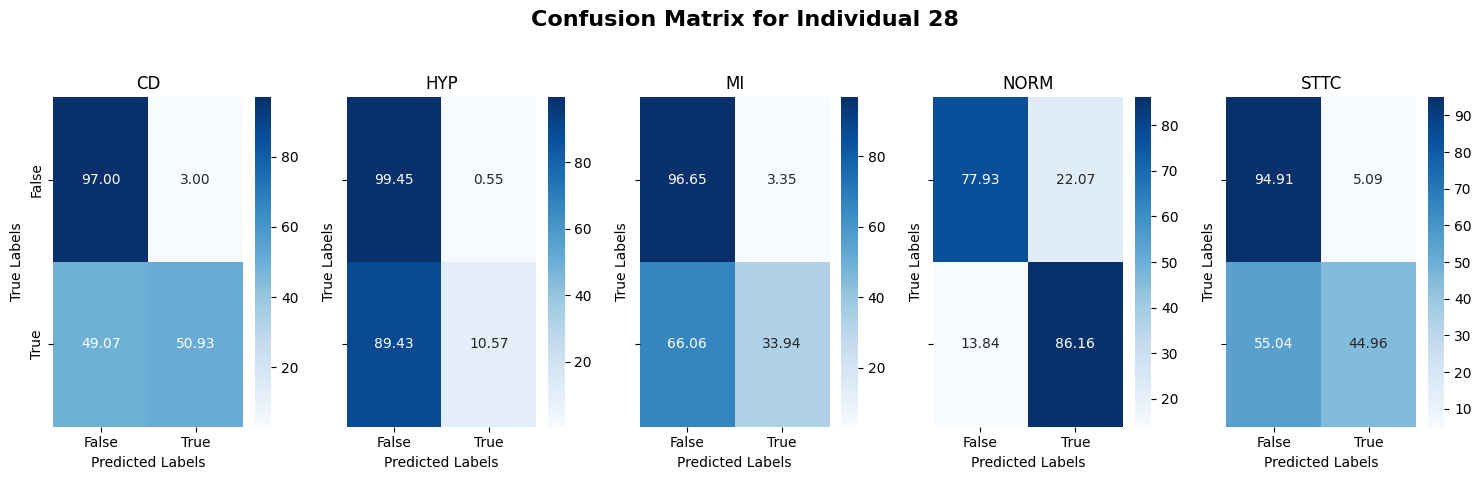

2024-04-16 04:02:56,649 - INFO - Calculating fitness for individual 29/30


X_params shape: (1, 2)
n_neighbors: 19 p: 9


2024-04-16 04:03:02,562 - INFO - Fitness for individual 29: 0.849761176109314


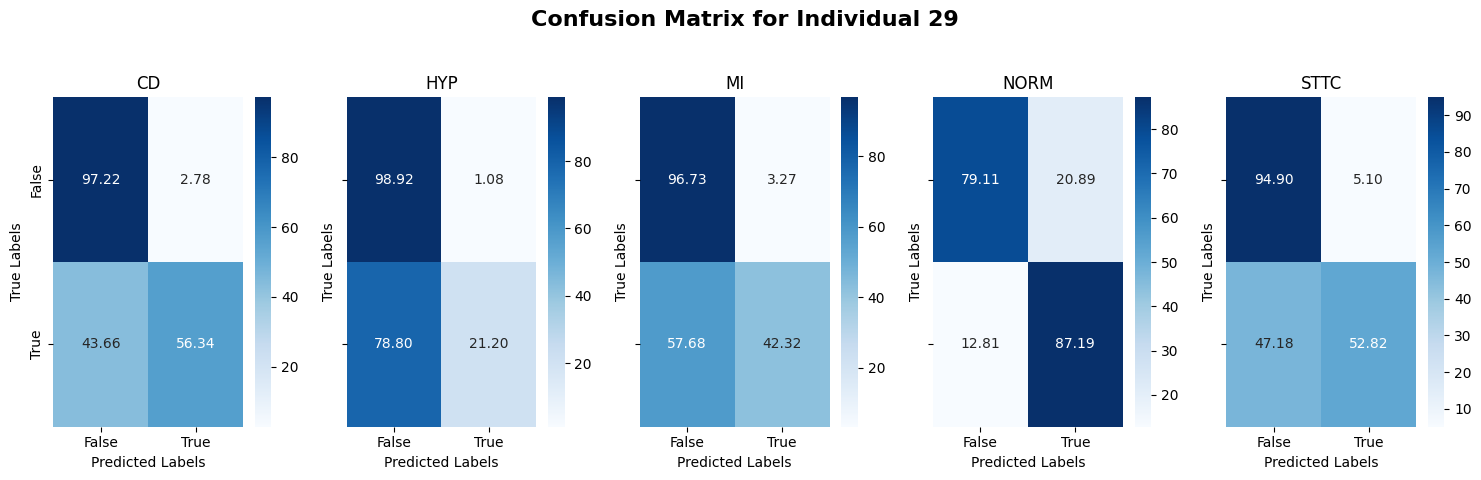

2024-04-16 04:03:04,406 - INFO - Calculating fitness for individual 30/30


X_params shape: (1, 2)
n_neighbors: 7 p: 22


2024-04-16 04:03:10,328 - INFO - Fitness for individual 30: 0.8791601777076721


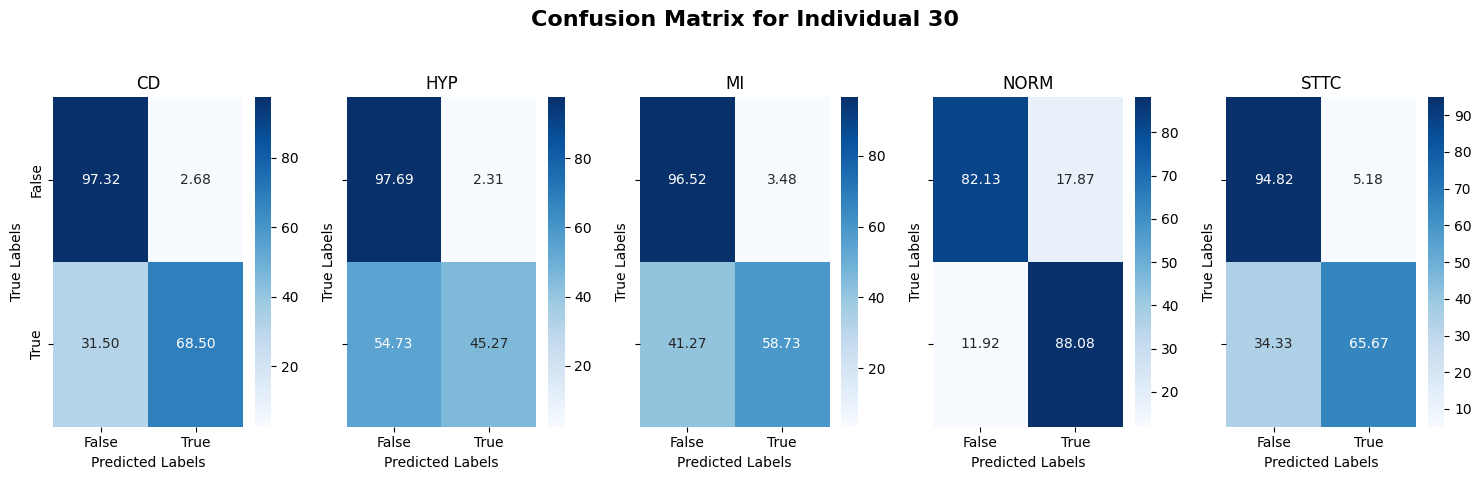

2024-04-16 04:03:12,510 - INFO - Calculating fitness for individual after 3 Phases 1/30


X_params shape: (1, 2)
n_neighbors: 3 p: 2


2024-04-16 04:03:18,345 - INFO - Fitness for individual 1: 0.8978008270263672


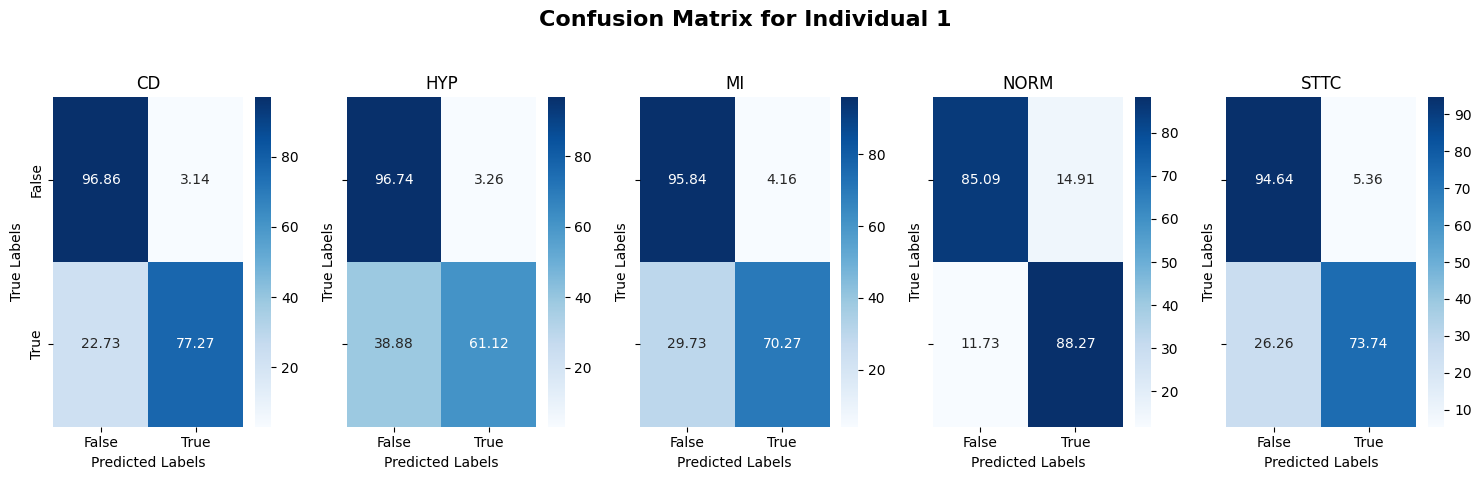

2024-04-16 04:03:20,200 - INFO - Calculating fitness for individual after 3 Phases 2/30


X_params shape: (1, 2)
n_neighbors: 2 p: 31


2024-04-16 04:03:26,256 - INFO - Fitness for individual 2: 0.8964573025703431


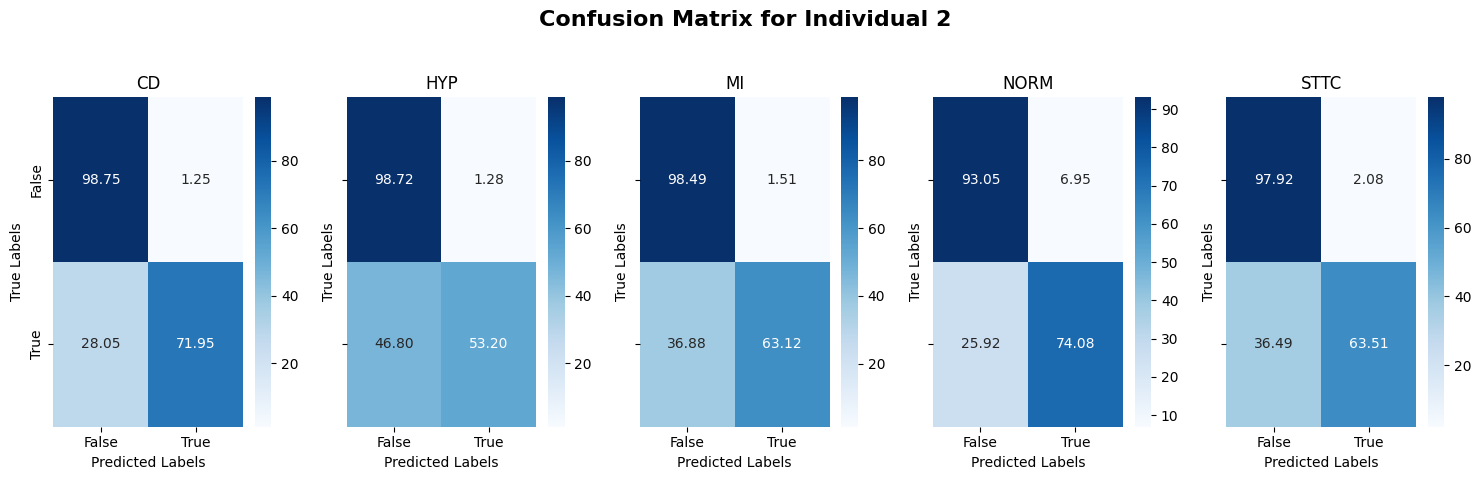

2024-04-16 04:03:28,093 - INFO - Calculating fitness for individual after 3 Phases 3/30


X_params shape: (1, 2)
n_neighbors: 33 p: 17


2024-04-16 04:03:34,815 - INFO - Fitness for individual 3: 0.8340834140777588


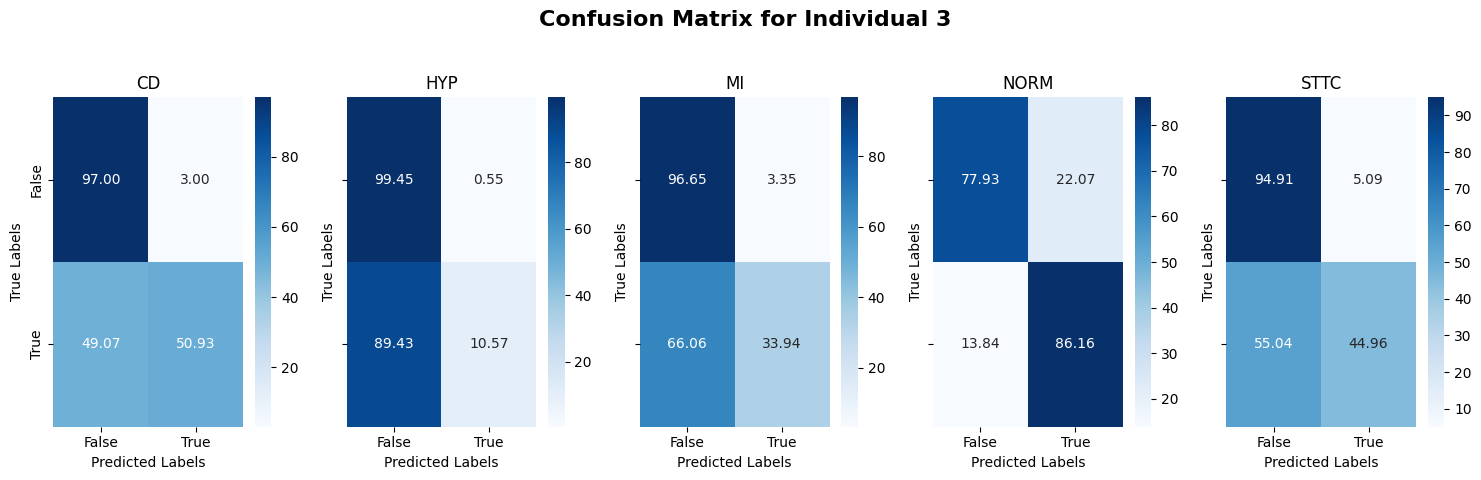

2024-04-16 04:03:36,676 - INFO - Calculating fitness for individual after 3 Phases 4/30


X_params shape: (1, 2)
n_neighbors: 28 p: 5


2024-04-16 04:03:42,596 - INFO - Fitness for individual 4: 0.8368879437446595


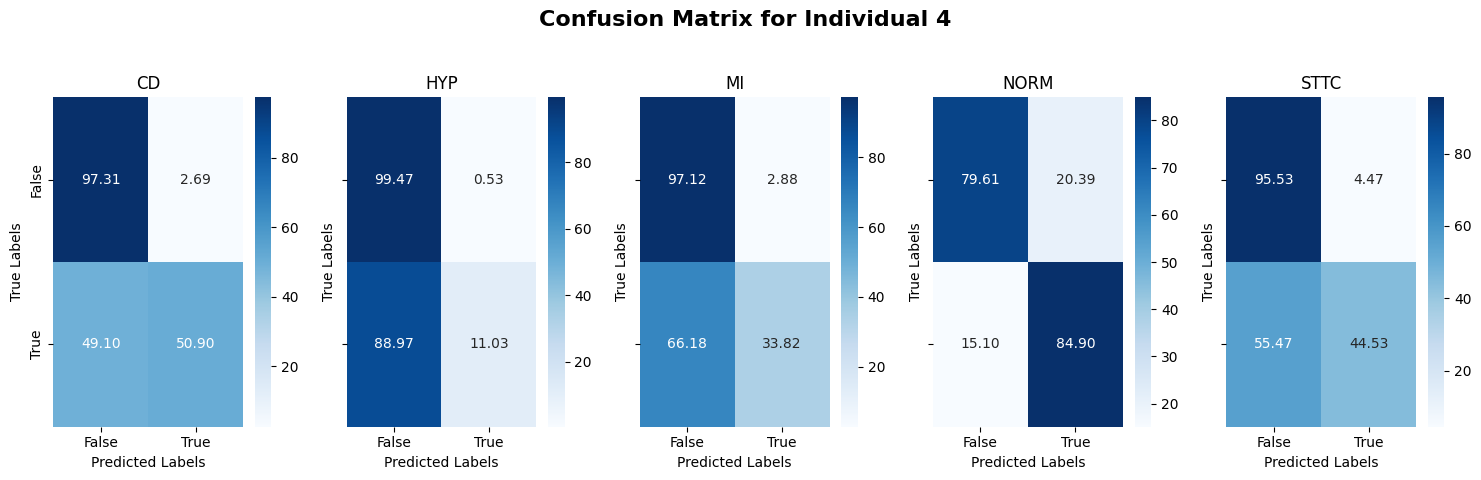

2024-04-16 04:03:44,405 - INFO - Calculating fitness for individual after 3 Phases 5/30


X_params shape: (1, 2)
n_neighbors: 8 p: 15


2024-04-16 04:03:50,691 - INFO - Fitness for individual 5: 0.8727388739585876


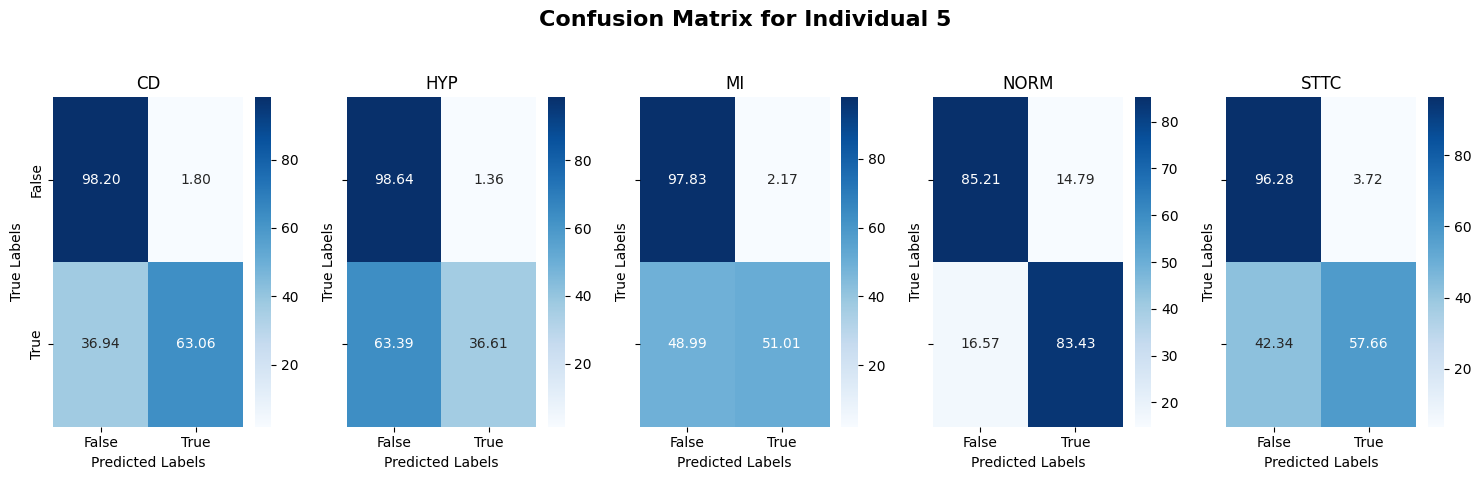

2024-04-16 04:03:52,516 - INFO - Calculating fitness for individual after 3 Phases 6/30


X_params shape: (1, 2)
n_neighbors: 2 p: 21


2024-04-16 04:03:58,359 - INFO - Fitness for individual 6: 0.8964573025703431


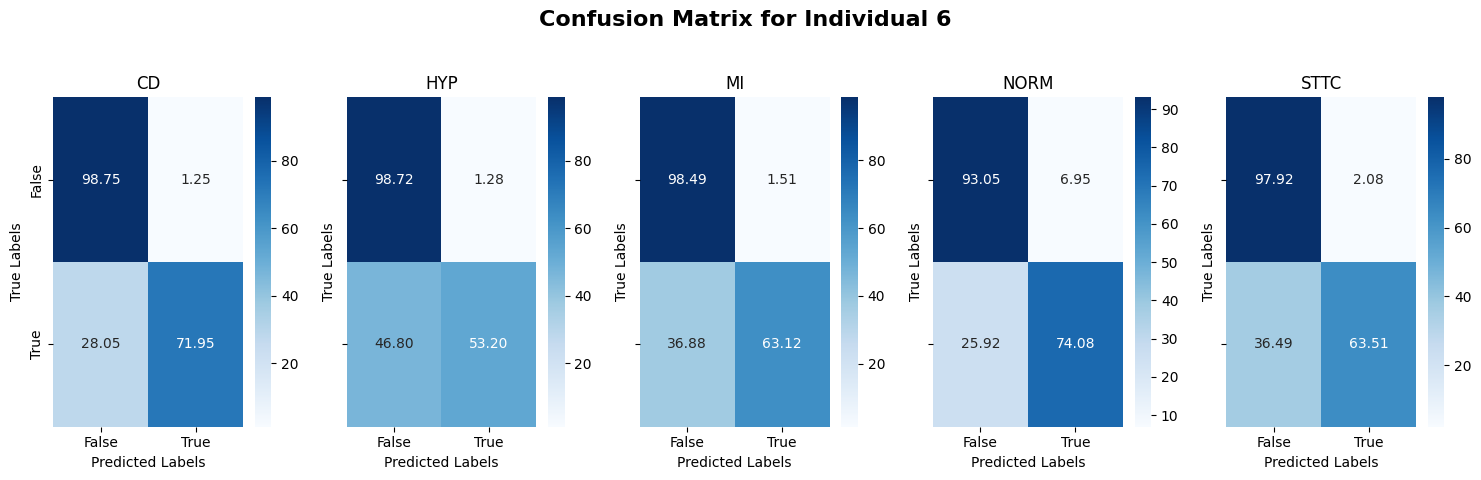

2024-04-16 04:04:00,198 - INFO - Calculating fitness for individual after 3 Phases 7/30


X_params shape: (1, 2)
n_neighbors: 2 p: 20


2024-04-16 04:04:06,001 - INFO - Fitness for individual 7: 0.8964573025703431


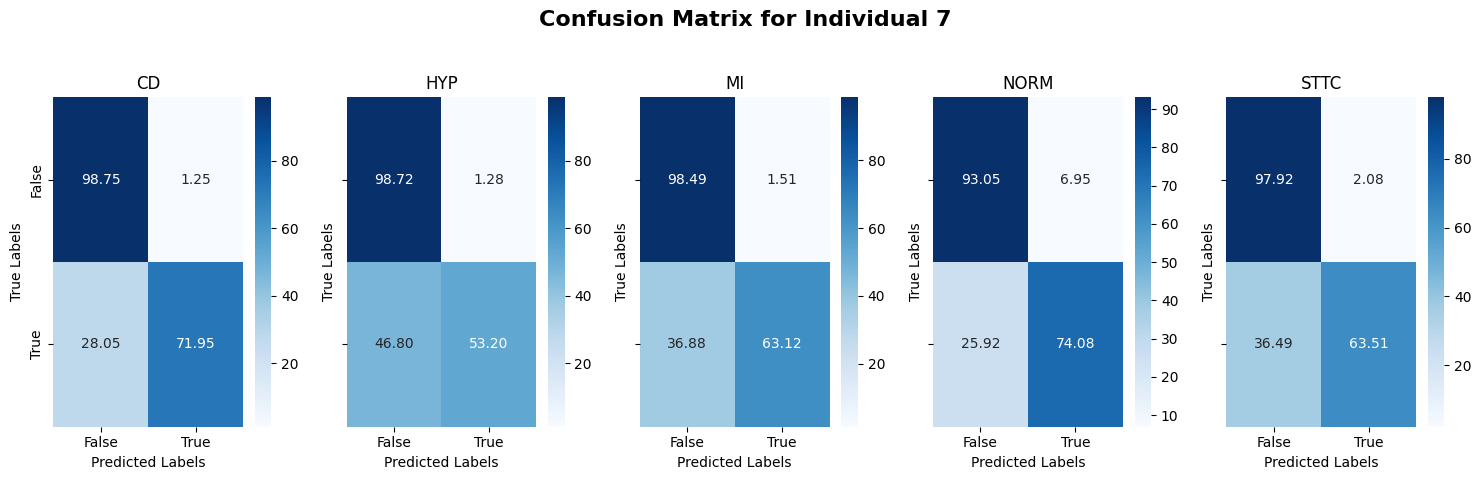

2024-04-16 04:04:07,859 - INFO - Calculating fitness for individual after 3 Phases 8/30


X_params shape: (1, 2)
n_neighbors: 2 p: 23


2024-04-16 04:04:13,588 - INFO - Fitness for individual 8: 0.8964573025703431


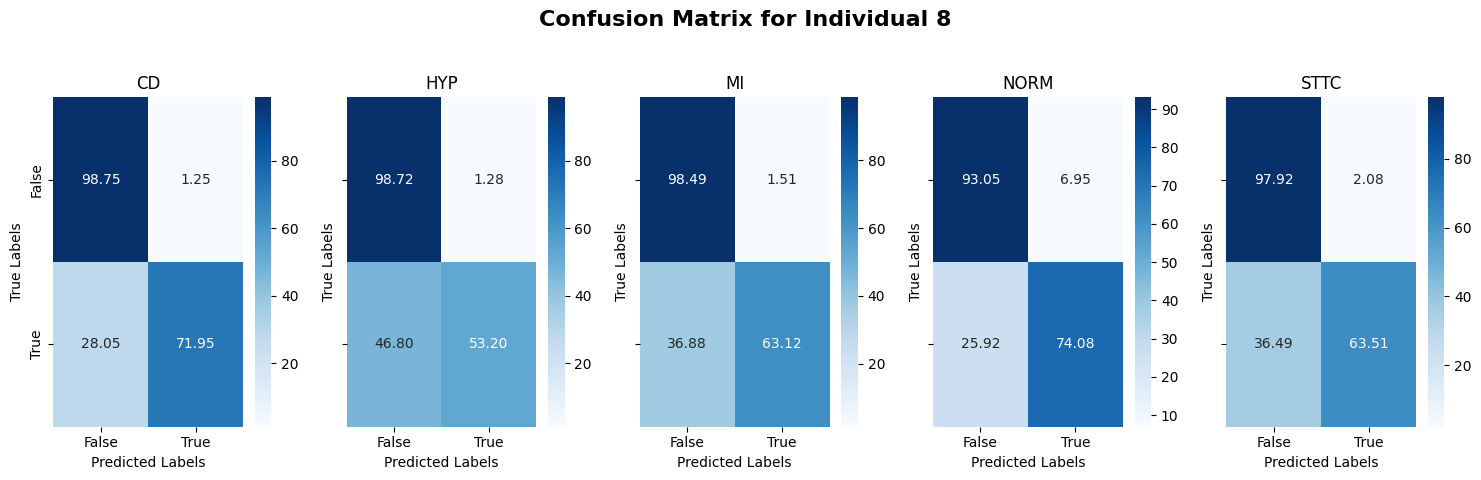

2024-04-16 04:04:15,422 - INFO - Calculating fitness for individual after 3 Phases 9/30


X_params shape: (1, 2)
n_neighbors: 18 p: 19


2024-04-16 04:04:21,308 - INFO - Fitness for individual 9: 0.8495313048362731


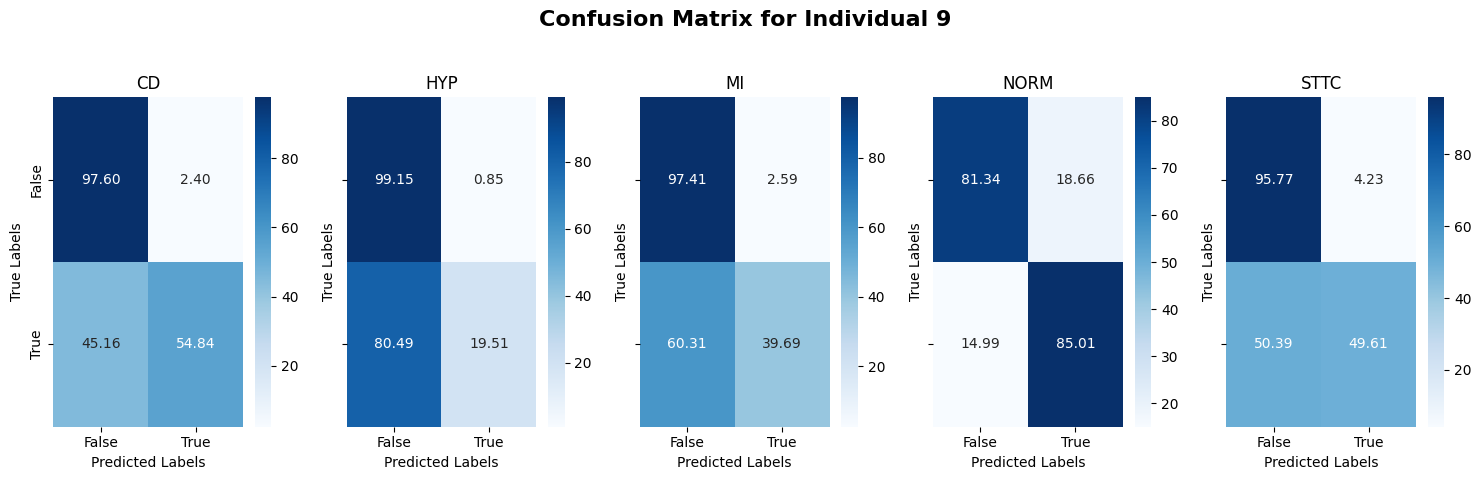

2024-04-16 04:04:23,434 - INFO - Calculating fitness for individual after 3 Phases 10/30


X_params shape: (1, 2)
n_neighbors: 33 p: 23


2024-04-16 04:04:30,219 - INFO - Fitness for individual 10: 0.8340834140777588


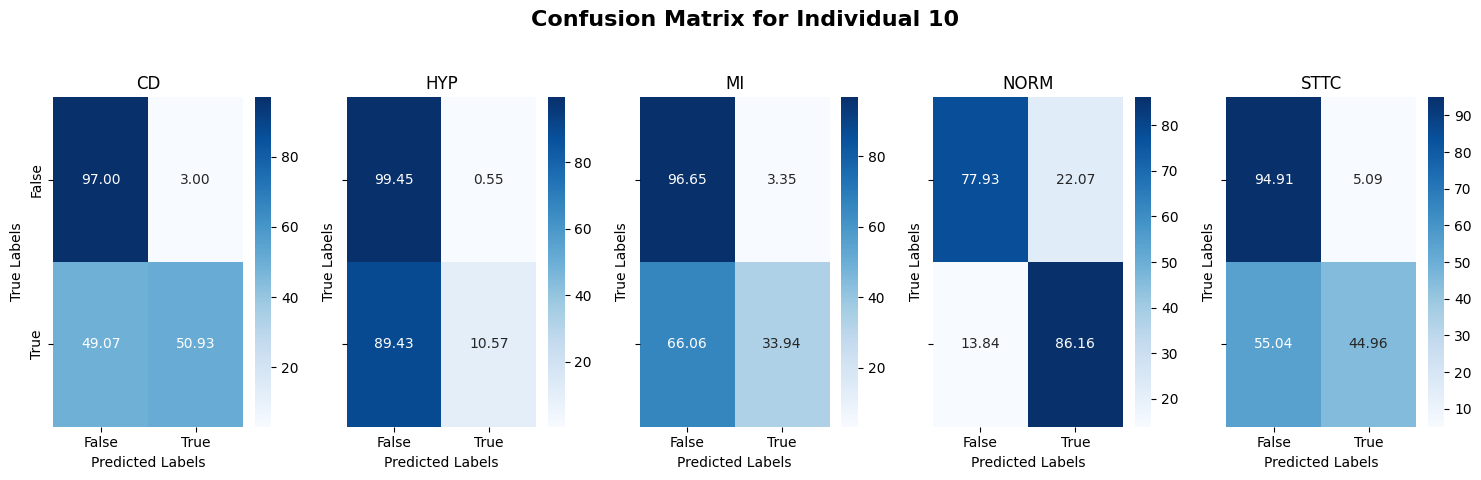

2024-04-16 04:04:32,088 - INFO - Calculating fitness for individual after 3 Phases 11/30


X_params shape: (1, 2)
n_neighbors: 27 p: 17


2024-04-16 04:04:38,223 - INFO - Fitness for individual 11: 0.8386299133300781


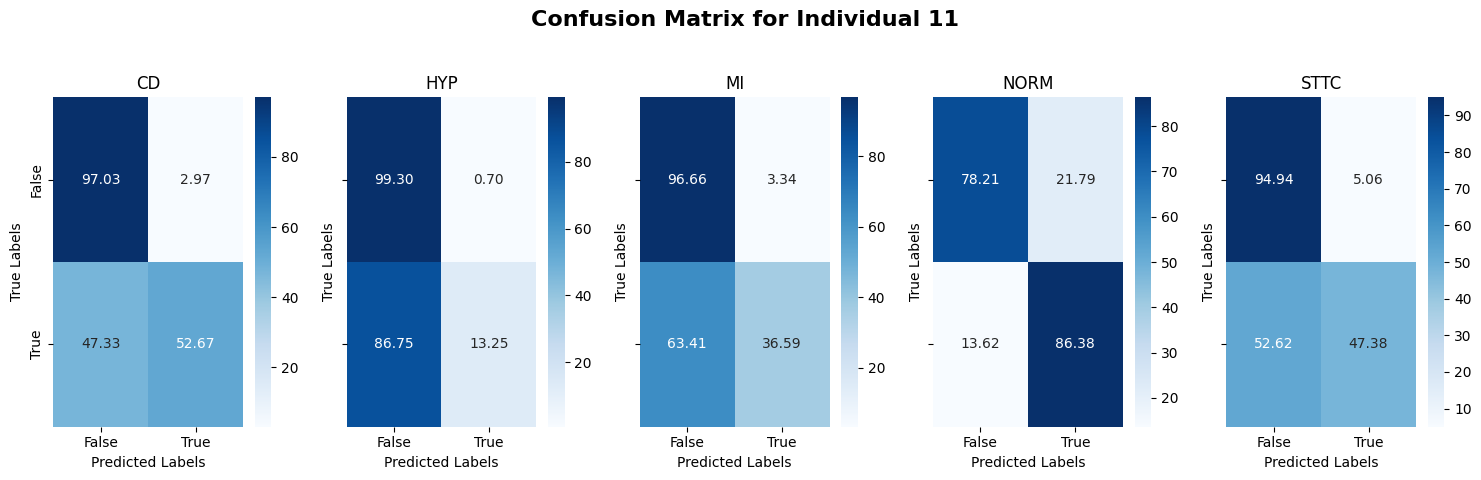

2024-04-16 04:04:40,092 - INFO - Calculating fitness for individual after 3 Phases 12/30


X_params shape: (1, 2)
n_neighbors: 5 p: 14


2024-04-16 04:04:46,145 - INFO - Fitness for individual 12: 0.887165081501007


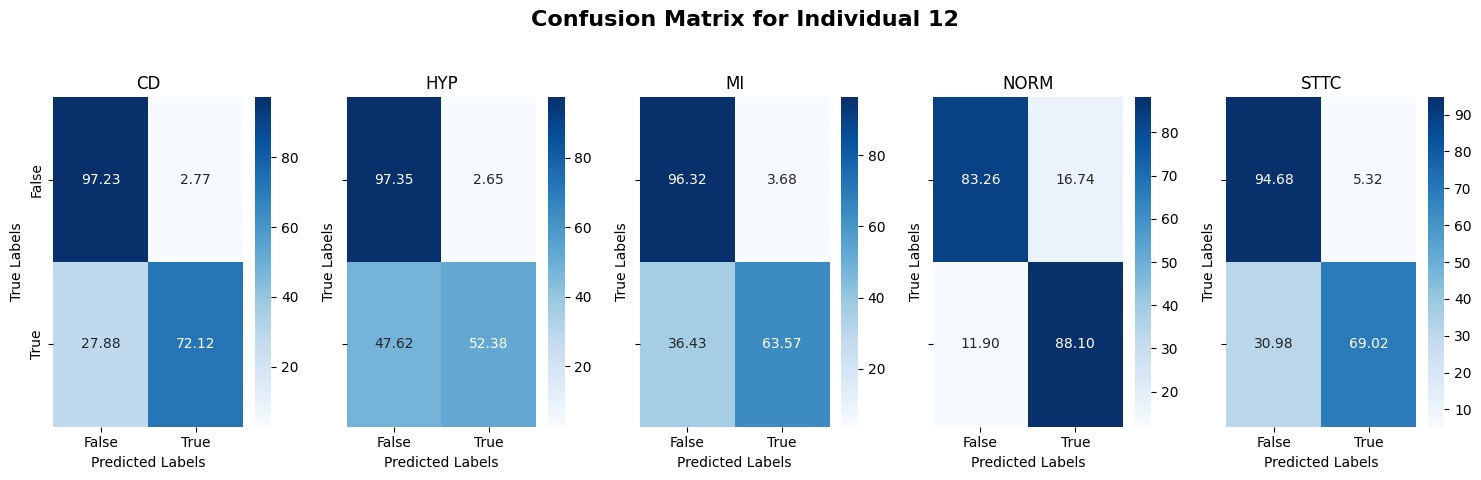

2024-04-16 04:04:48,004 - INFO - Calculating fitness for individual after 3 Phases 13/30


X_params shape: (1, 2)
n_neighbors: 37 p: 22


2024-04-16 04:04:54,764 - INFO - Fitness for individual 13: 0.8317590951919556


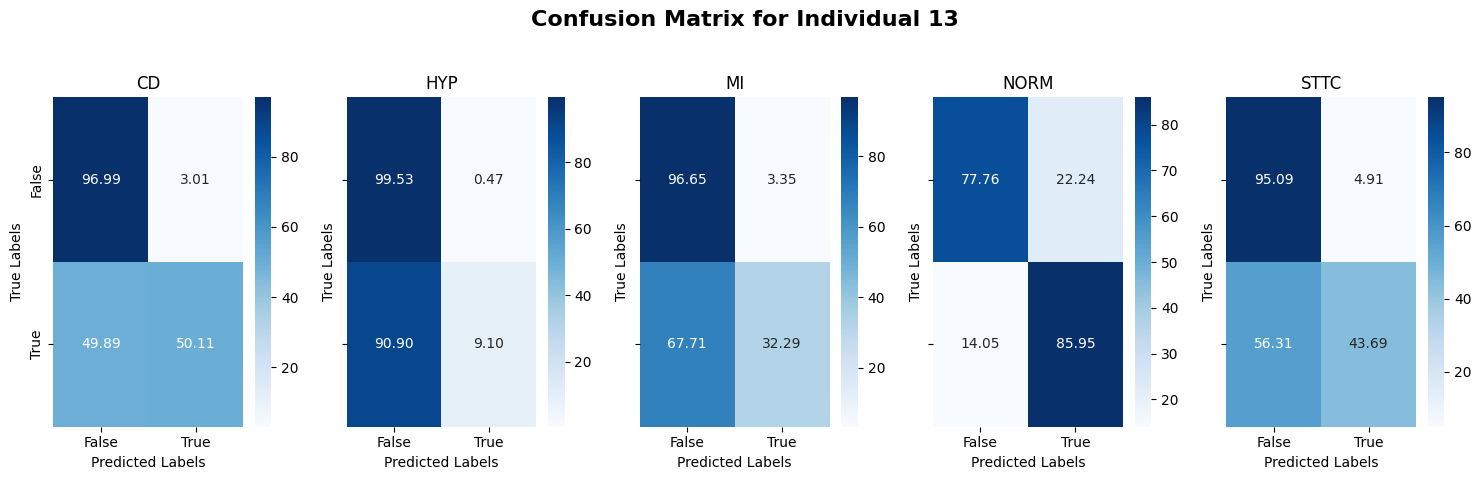

2024-04-16 04:04:56,576 - INFO - Calculating fitness for individual after 3 Phases 14/30


X_params shape: (1, 2)
n_neighbors: 39 p: 16


2024-04-16 04:05:03,336 - INFO - Fitness for individual 14: 0.8305432915687561


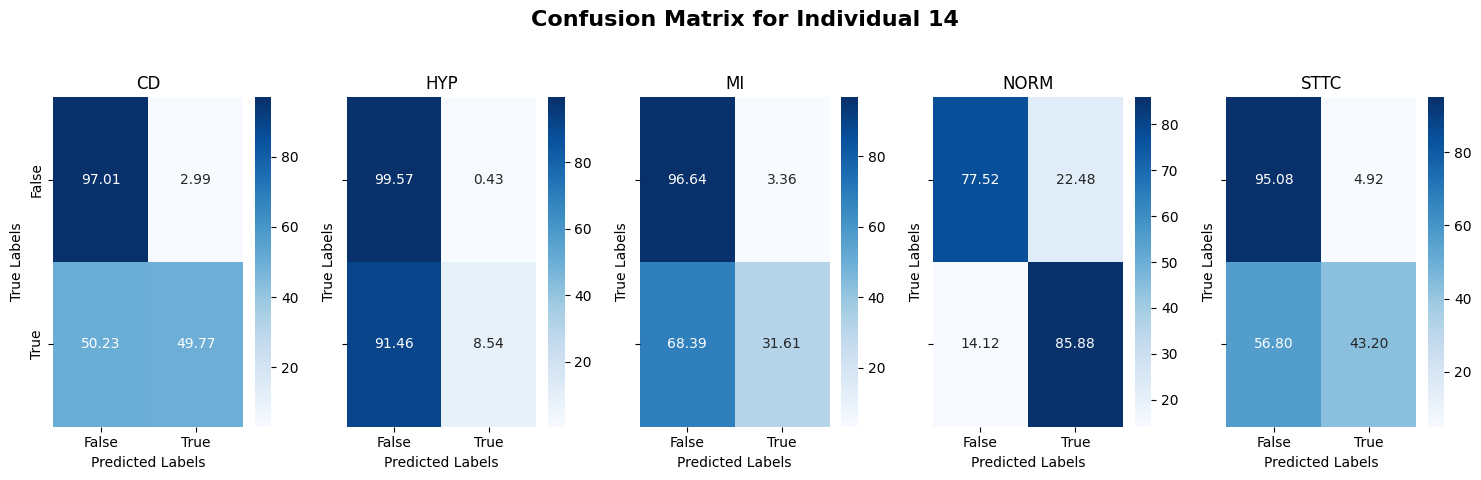

2024-04-16 04:05:05,473 - INFO - Calculating fitness for individual after 3 Phases 15/30


X_params shape: (1, 2)
n_neighbors: 28 p: 15


2024-04-16 04:05:11,399 - INFO - Fitness for individual 15: 0.8368879437446595


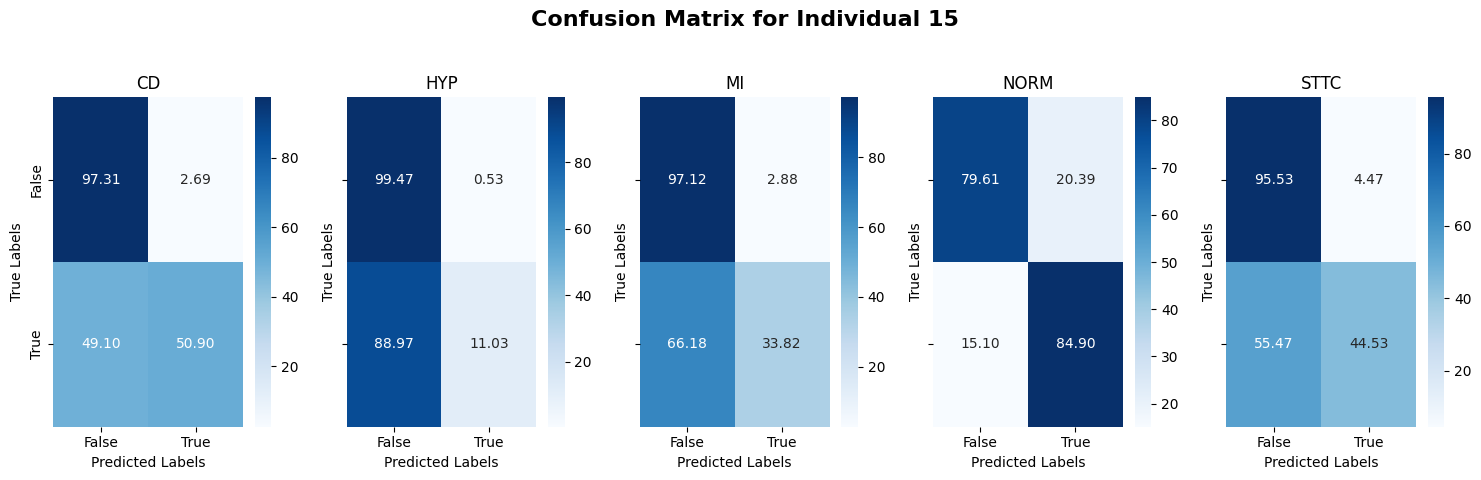

2024-04-16 04:05:13,222 - INFO - Calculating fitness for individual after 3 Phases 16/30


X_params shape: (1, 2)
n_neighbors: 13 p: 32


2024-04-16 04:05:19,229 - INFO - Fitness for individual 16: 0.8618783593177796


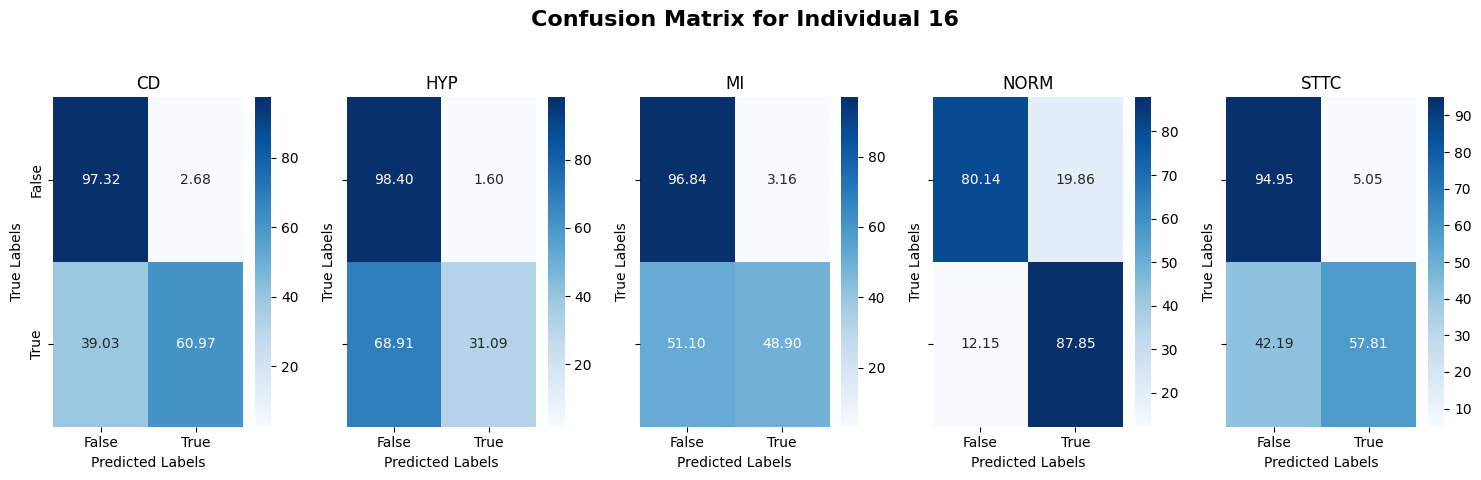

2024-04-16 04:05:21,091 - INFO - Calculating fitness for individual after 3 Phases 17/30


X_params shape: (1, 2)
n_neighbors: 8 p: 16


2024-04-16 04:05:27,089 - INFO - Fitness for individual 17: 0.8727388739585876


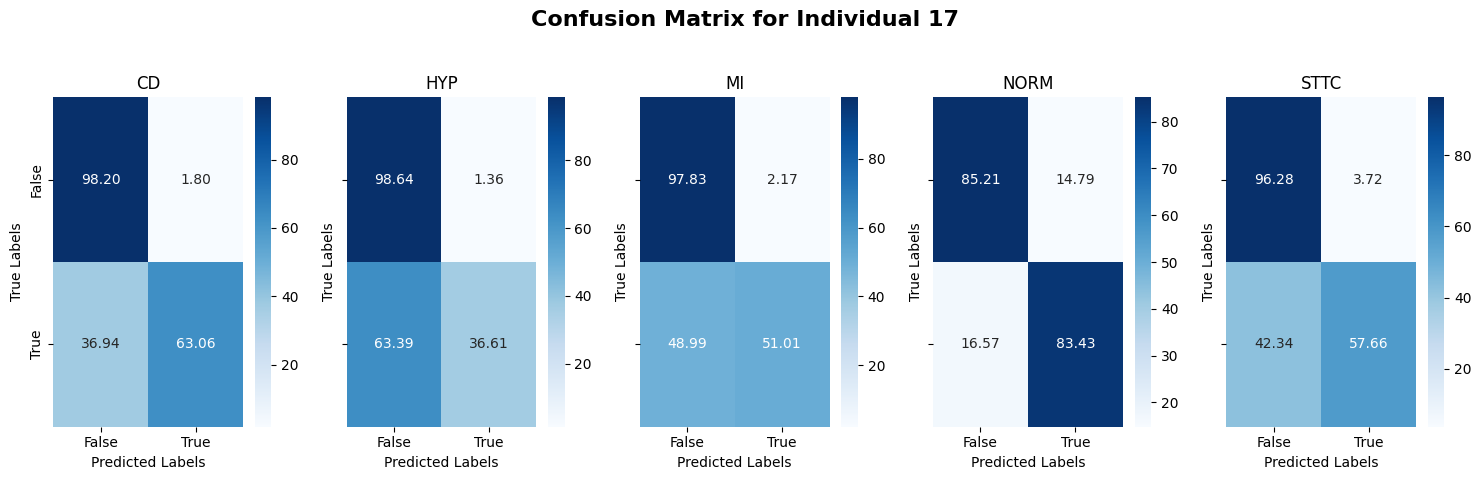

2024-04-16 04:05:28,903 - INFO - Calculating fitness for individual after 3 Phases 18/30


X_params shape: (1, 2)
n_neighbors: 34 p: 38


2024-04-16 04:05:35,545 - INFO - Fitness for individual 18: 0.8324487209320068


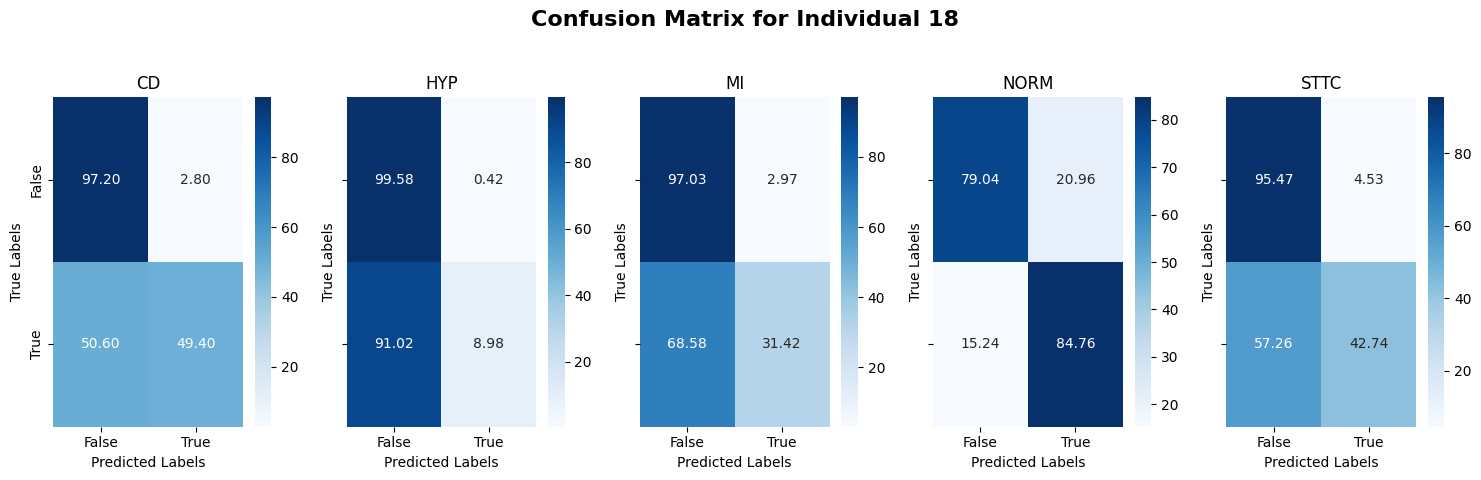

2024-04-16 04:05:37,359 - INFO - Calculating fitness for individual after 3 Phases 19/30


X_params shape: (1, 2)
n_neighbors: 18 p: 35


2024-04-16 04:05:43,326 - INFO - Fitness for individual 19: 0.8495313048362731


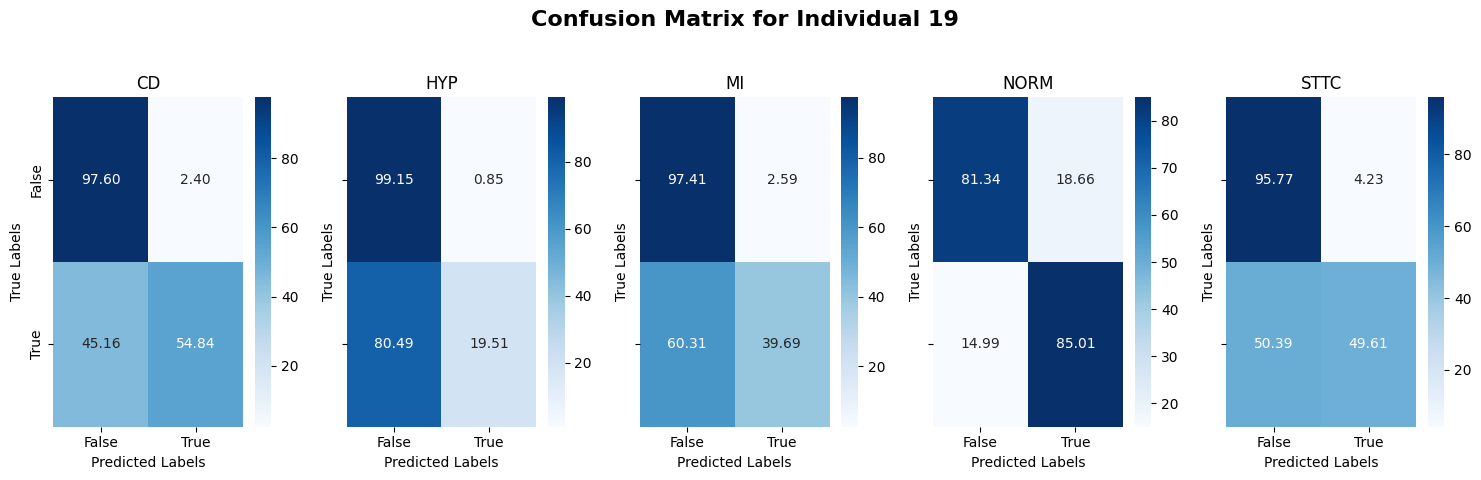

2024-04-16 04:05:45,467 - INFO - Calculating fitness for individual after 3 Phases 20/30


X_params shape: (1, 2)
n_neighbors: 52 p: 14


2024-04-16 04:05:52,282 - INFO - Fitness for individual 20: 0.8241526365280152


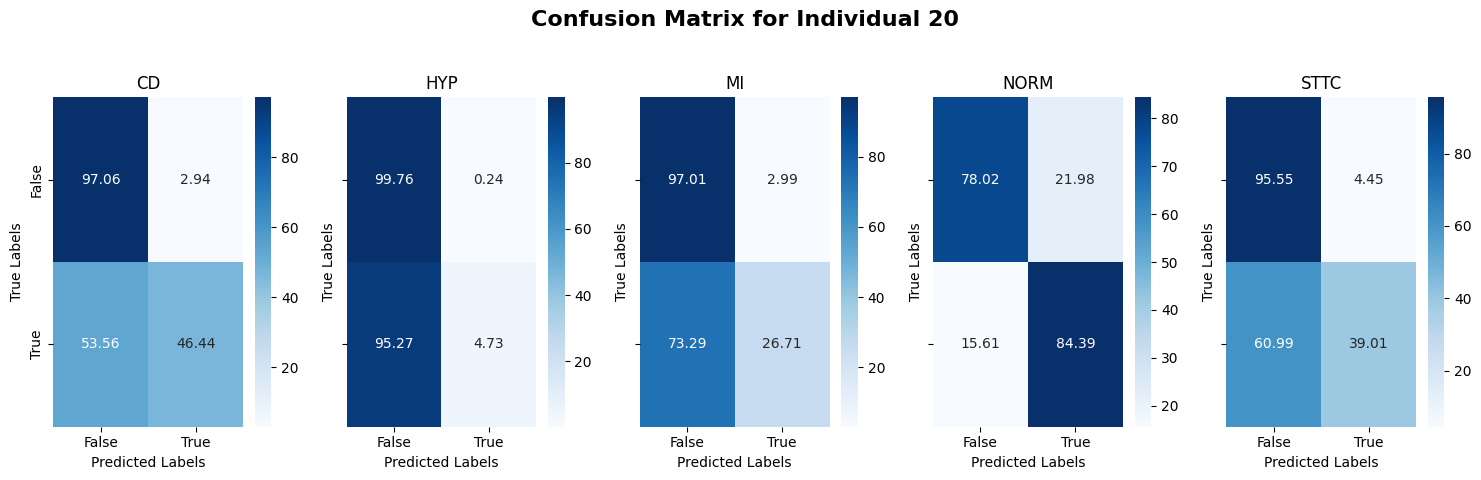

2024-04-16 04:05:54,101 - INFO - Calculating fitness for individual after 3 Phases 21/30


X_params shape: (1, 2)
n_neighbors: 12 p: 40


2024-04-16 04:06:00,029 - INFO - Fitness for individual 21: 0.8615718603134155


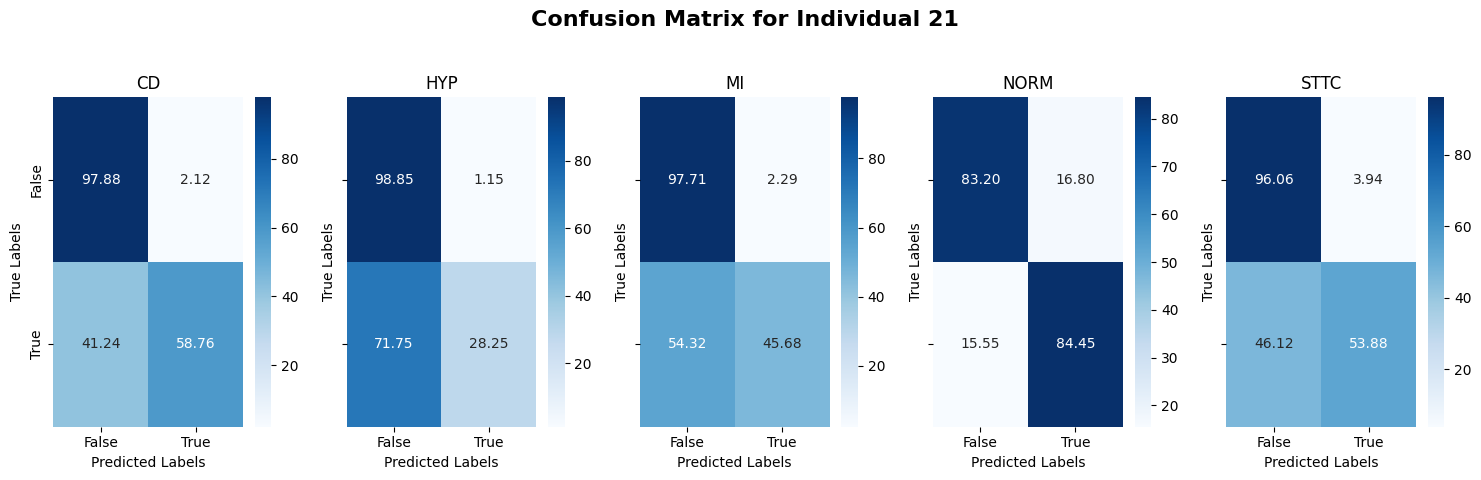

2024-04-16 04:06:01,851 - INFO - Calculating fitness for individual after 3 Phases 22/30


X_params shape: (1, 2)
n_neighbors: 7 p: 2


2024-04-16 04:06:07,833 - INFO - Fitness for individual 22: 0.8791601777076721


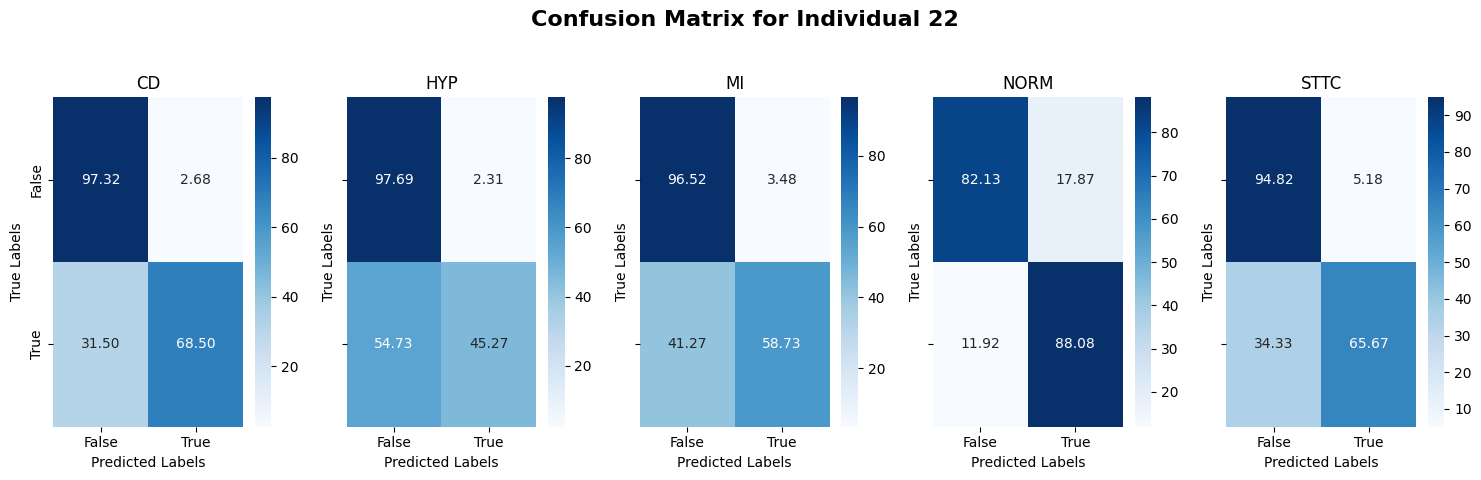

2024-04-16 04:06:09,711 - INFO - Calculating fitness for individual after 3 Phases 23/30


X_params shape: (1, 2)
n_neighbors: 13 p: 9


2024-04-16 04:06:15,741 - INFO - Fitness for individual 23: 0.8618783593177796


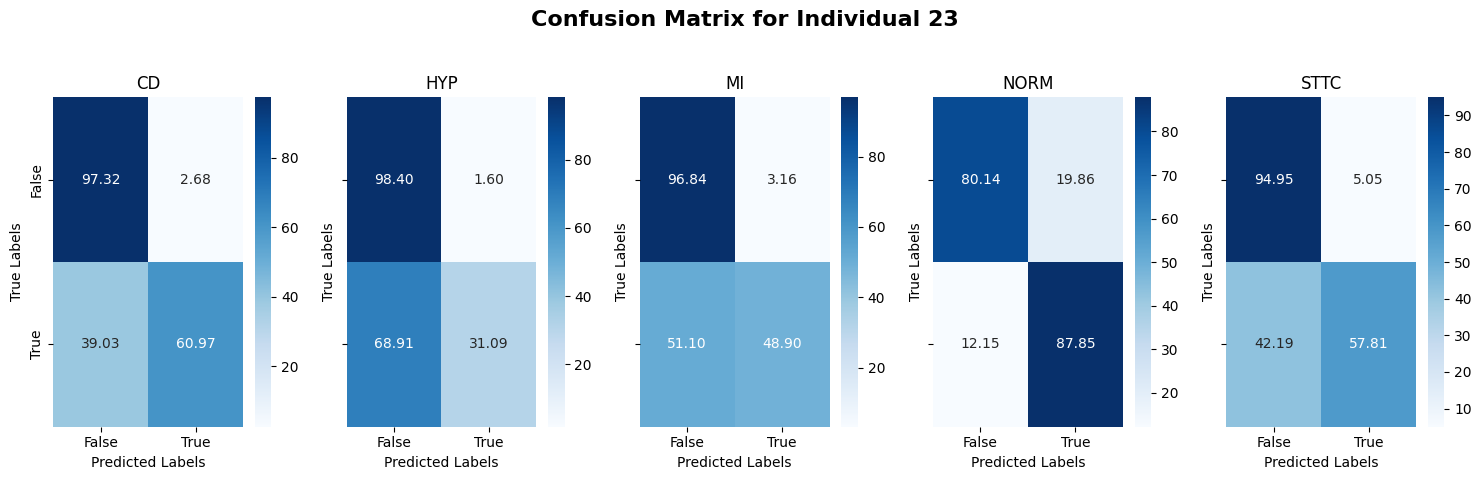

2024-04-16 04:06:17,600 - INFO - Calculating fitness for individual after 3 Phases 24/30


X_params shape: (1, 2)
n_neighbors: 40 p: 10


2024-04-16 04:06:24,425 - INFO - Fitness for individual 24: 0.829179322719574


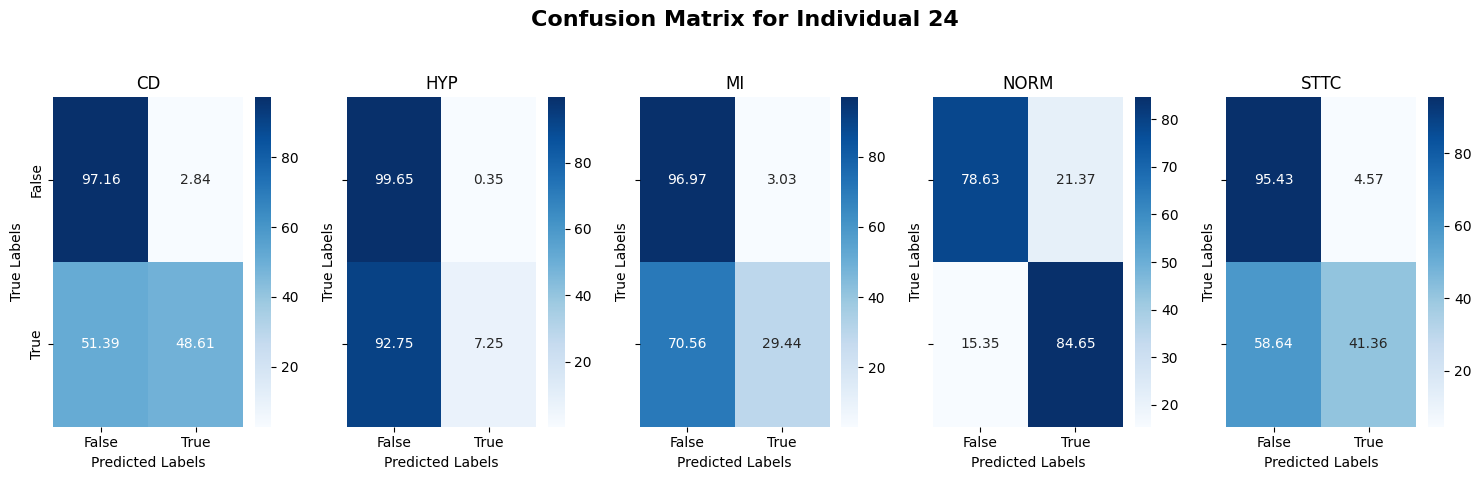

2024-04-16 04:06:26,597 - INFO - Calculating fitness for individual after 3 Phases 25/30


X_params shape: (1, 2)
n_neighbors: 7 p: 13


2024-04-16 04:06:32,732 - INFO - Fitness for individual 25: 0.8791601777076721


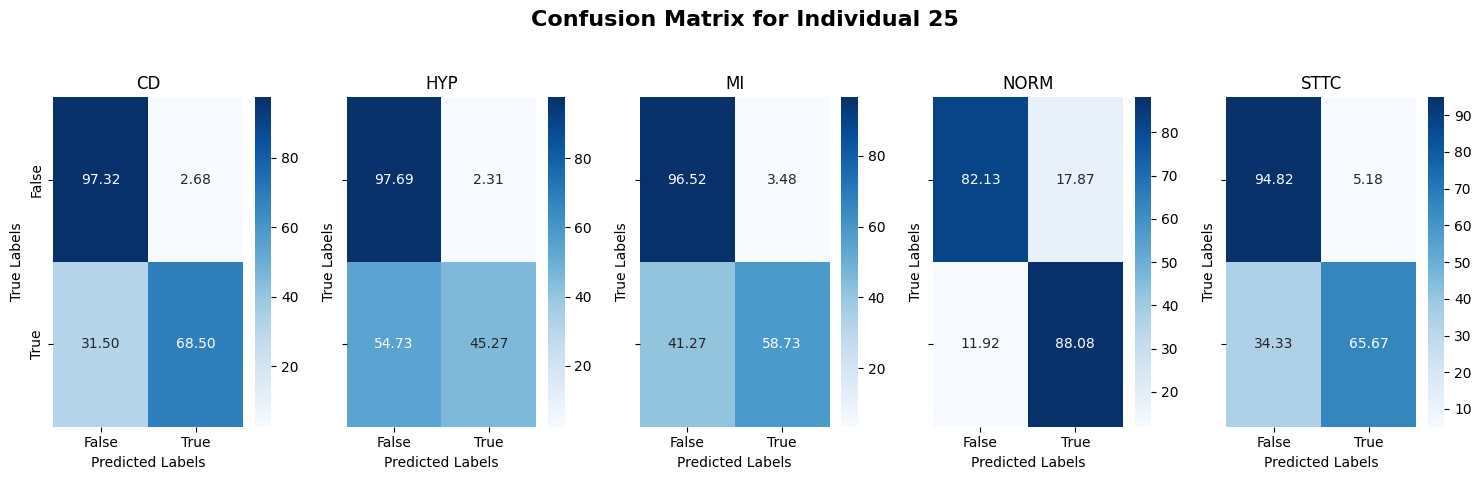

2024-04-16 04:06:34,611 - INFO - Calculating fitness for individual after 3 Phases 26/30


X_params shape: (1, 2)
n_neighbors: 34 p: 4


2024-04-16 04:06:41,400 - INFO - Fitness for individual 26: 0.8324487209320068


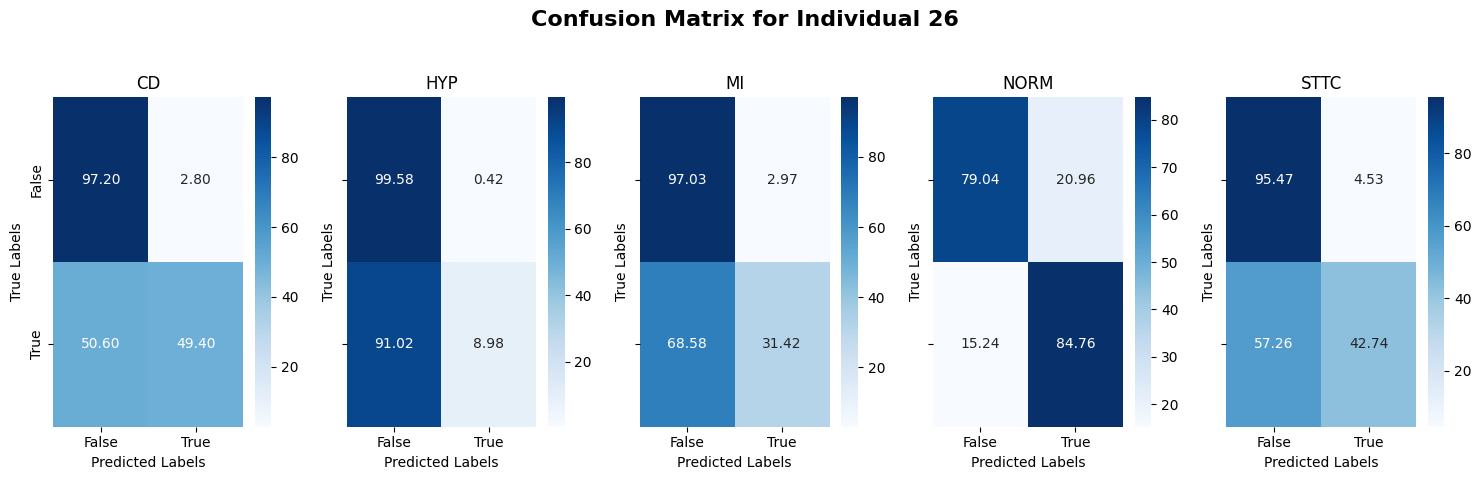

2024-04-16 04:06:43,314 - INFO - Calculating fitness for individual after 3 Phases 27/30


X_params shape: (1, 2)
n_neighbors: 4 p: 39


2024-04-16 04:06:49,187 - INFO - Fitness for individual 27: 0.8874766945838928


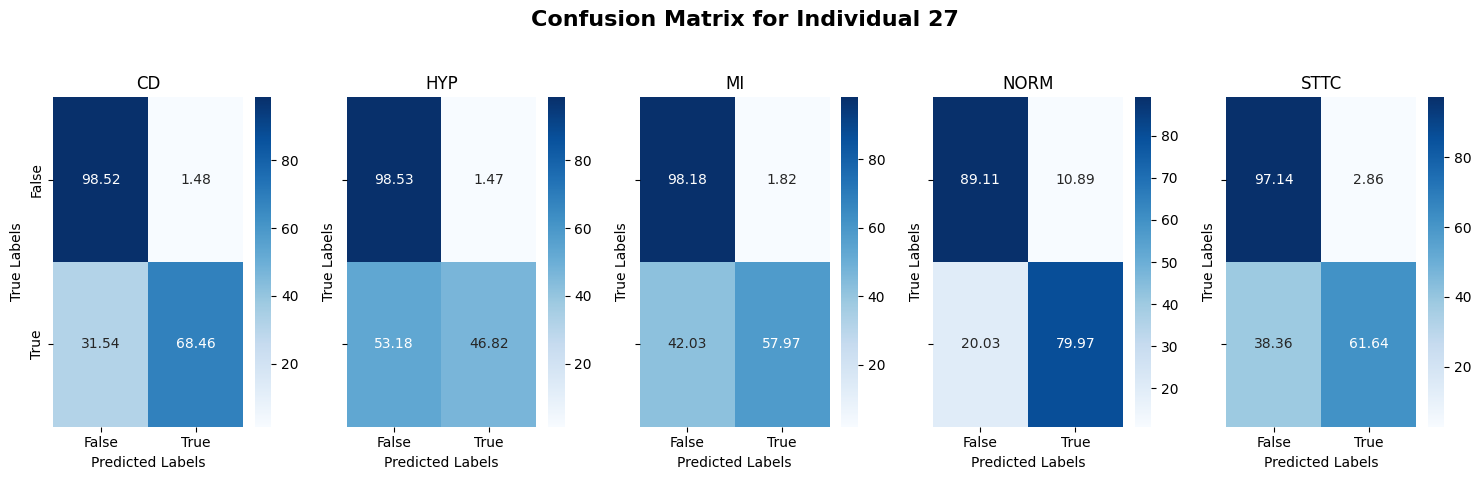

2024-04-16 04:06:50,983 - INFO - Calculating fitness for individual after 3 Phases 28/30


X_params shape: (1, 2)
n_neighbors: 31 p: 1


2024-04-16 04:06:56,898 - INFO - Fitness for individual 28: 0.835651695728302


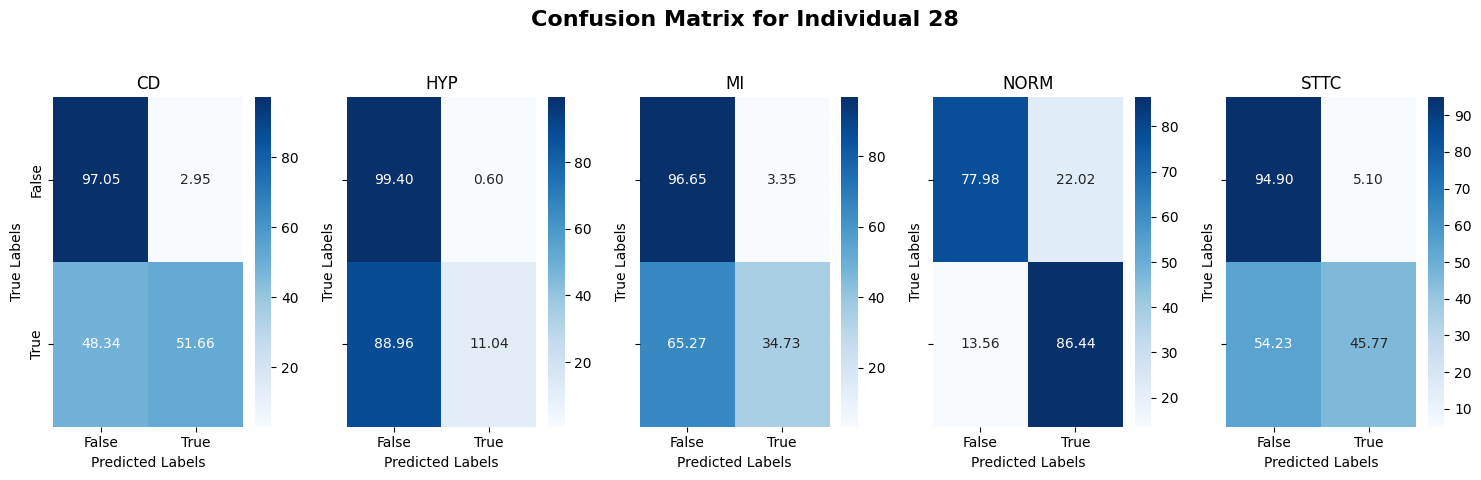

2024-04-16 04:06:59,034 - INFO - Calculating fitness for individual after 3 Phases 29/30


X_params shape: (1, 2)
n_neighbors: 19 p: 1


2024-04-16 04:07:04,942 - INFO - Fitness for individual 29: 0.849761176109314


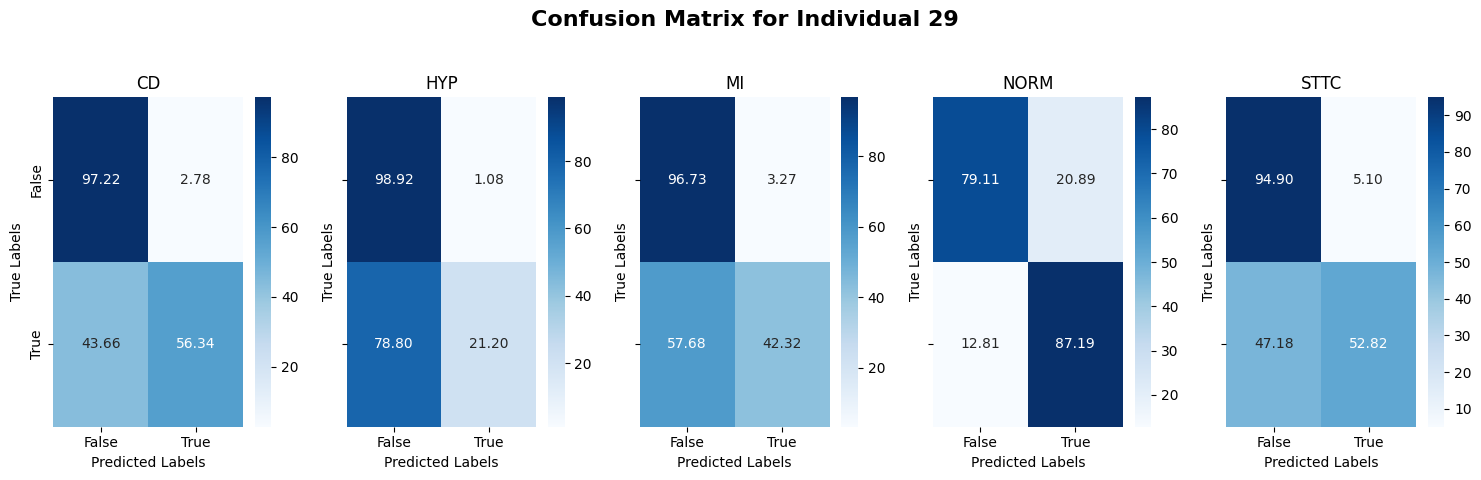

2024-04-16 04:07:06,788 - INFO - Calculating fitness for individual after 3 Phases 30/30


X_params shape: (1, 2)
n_neighbors: 7 p: 24


2024-04-16 04:07:12,666 - INFO - Fitness for individual 30: 0.8791601777076721


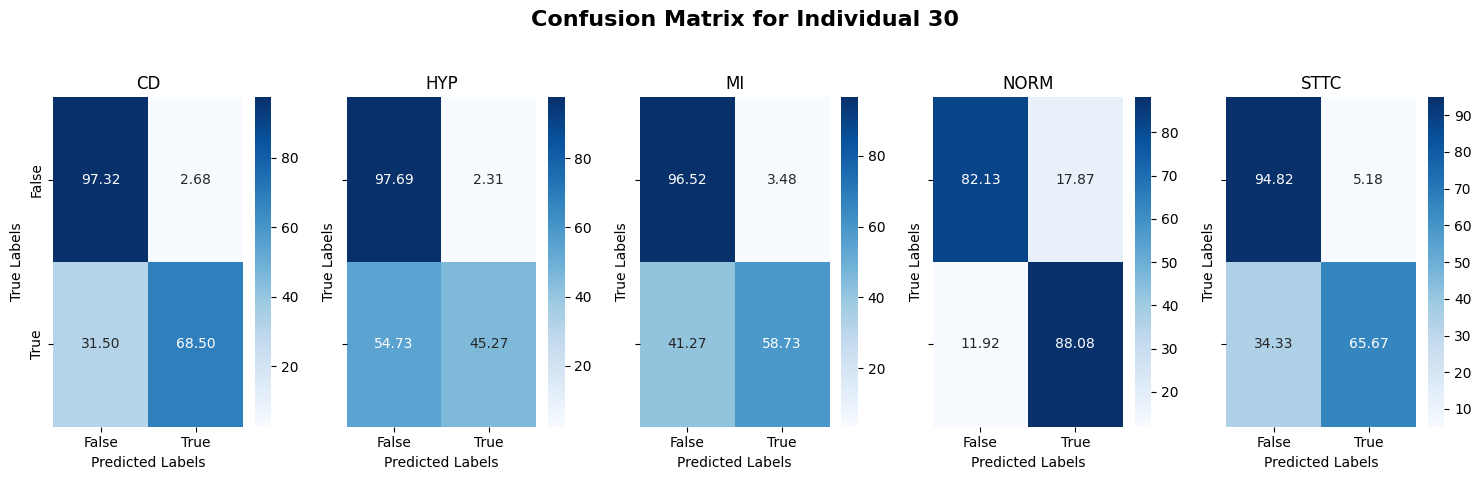

2024-04-16 04:07:14,509 - INFO - Iteration: 1/20, Best Fitness: 0.8978008270263672, Average Fitness: 0.8590712857246399
2024-04-16 04:07:14,511 - INFO - Fitness threshold reached: 0.8978008270263672 at iteration 1. Terminating...
2024-04-16 04:07:14,513 - INFO - Model saved to best_model_mpa_kNN_ptb_xl.pkl with fitness 0.8978008270263672 at iteration 1
2024-04-16 04:07:14,514 - INFO - Finished MPA_kNN optimization for PTB_XL dataset. Total duration: 8.12 minutes.
2024-04-16 04:07:14,515 - INFO - Top predator position (rounded to integers): [3, 20]
2024-04-16 04:07:14,516 - INFO - Top predator fitness: 0.8978008270263672


Top predator position (rounded to integers): [3, 20]
Top predator fitness: 0.8978008270263672


In [19]:
import time
import logging

def run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, kNN_accuracy_fitness, fitness_threshold=0.85):
    """
    Runs MPA optimization for all labels and plots the convergence curve for each label.

    Parameters:
    - X_train, X_val, y_train, y_val: Training and validation sets.
    - search_agents_no: Number of search agents.
    - Max_iter: Maximum number of iterations.
    - lb, ub: Lower and upper bounds for optimization parameters.
    - dim: Number of dimensions/hyperparameters.
    - kNN_accuracy_fitness: Fitness function for the k-NN model.
    - fitness_threshold: Threshold for stopping the optimization.
    """
    overall_start_time = time.time()

    # Example usage with correctly structured return values for MPA
    results = {}  # Assuming MPA should populate this dictionary
    
    # Example call to MPA for one label (extend as needed for multiple labels)
    top_predator_pos, top_predator_fit = MPA(
        search_agents_no, Max_iter, lb, ub, dim, 
        X_train, y_train, X_val, y_val, 
        kNN_accuracy_fitness, fitness_threshold
    )
    
    # Rounding top predator position to nearest integers for logging and usage
    rounded_top_predator_pos = [round(pos) for pos in top_predator_pos]

    # Populate the results dictionary with mock label data (extend as needed)
    results['MockLabel'] = {
        'Top_predator_pos': rounded_top_predator_pos,
        'Top_predator_fitness': top_predator_fit
    }

    overall_end_time = time.time()
    total_duration_minutes = (overall_end_time - overall_start_time) / 60

    # Get the top predator position and fitness from the 'results' dictionary for the mock label
    top_predator_pos = results['MockLabel']['Top_predator_pos']
    top_predator_fit = results['MockLabel']['Top_predator_fitness']
    
    # Log the top predator fitness and position
    logging.info(f"Finished MPA_kNN optimization for PTB_XL dataset. Total duration: {total_duration_minutes:.2f} minutes.")
    logging.info(f"Top predator position (rounded to integers): {top_predator_pos}")
    logging.info(f"Top predator fitness: {top_predator_fit}")
    
    # Optionally, print them out to the console as well
    print(f"Top predator position (rounded to integers): {top_predator_pos}")
    print(f"Top predator fitness: {top_predator_fit}")


run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, kNN_accuracy_fitness, fitness_threshold=0.85)


### Evaluating on Test Dataset

In [20]:
import cudf
# Example loading test data (adjust path and processing as needed)
test_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Test_new.csv')

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

X_test = test_data[features].astype('float32')
y_test = test_data[labels].astype('int32')  # Adjust label column as per your dataset


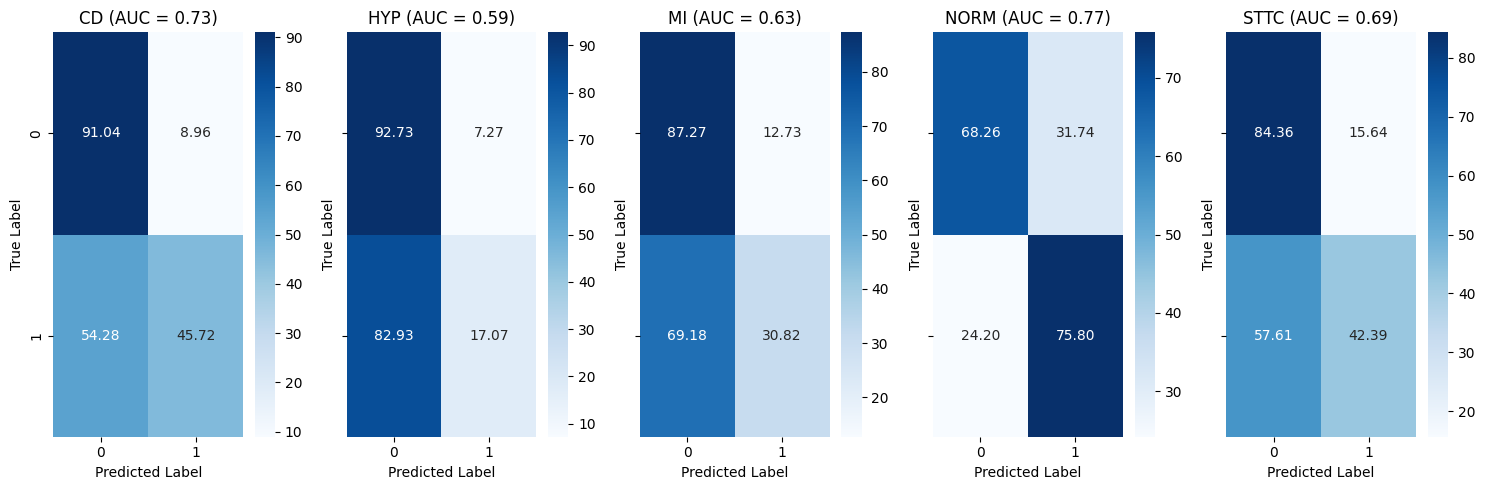

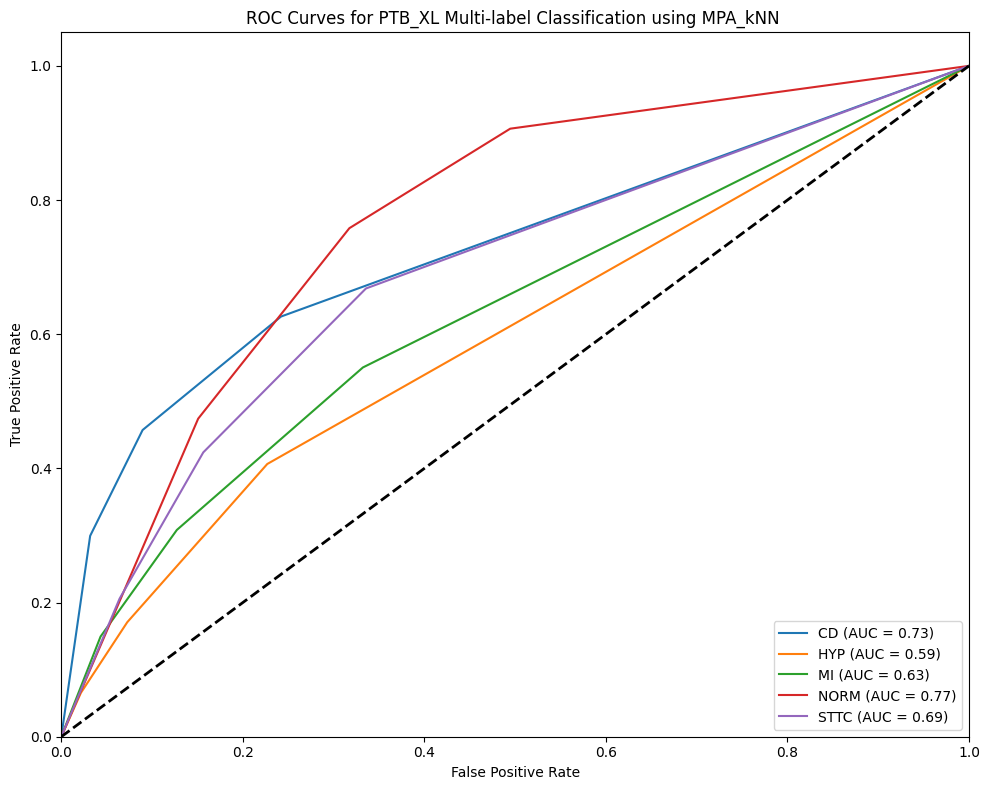

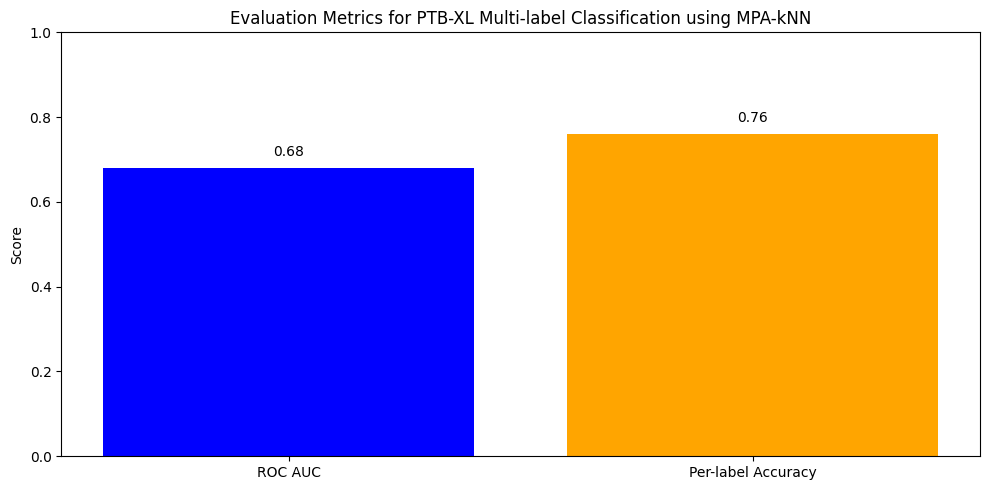

Classification Report for CD:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     16785
           1       0.62      0.46      0.52      5280

    accuracy                           0.80     22065
   macro avg       0.73      0.68      0.70     22065
weighted avg       0.79      0.80      0.79     22065

Classification Report for HYP:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     19283
           1       0.25      0.17      0.20      2782

    accuracy                           0.83     22065
   macro avg       0.57      0.55      0.55     22065
weighted avg       0.81      0.83      0.82     22065

Classification Report for MI:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     16079
           1       0.47      0.31      0.37      5986

    accuracy                           0.72     22065
   macro avg       0.62      0.59    

In [21]:
import cudf
import cupy as cp
from cuml.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from cuml import set_global_output_type
import numpy as np

# Set global output type to cupy for cuML compatibility with cuPy
set_global_output_type('cupy')

# Load the best model saved from MPA
with open('best_model_mpa_kNN_ptb_xl.pkl', 'rb') as f:
    model = pickle.load(f)

# Prepare to store predictions and probabilities
y_probs = {}
y_preds = {}
roc_aucs = []
accuracies = []

# Plot confusion matrices
num_labels = len(labels)
# Plot confusion matrices
fig_cm, axes_cm = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Create a new figure for confusion matrices

for idx, label in enumerate(labels):
    model.fit(X_train, y_train[label])
    # Predict probabilities and labels
    y_probs[label] = model.predict_proba(X_test)[:, 1]
    y_preds[label] = model.predict(X_test)
    
    # Convert to NumPy arrays for calculation
    y_true_np = y_test[label].to_numpy()
    y_score_np = cp.asnumpy(y_probs[label])

    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_true_np, y_score_np)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    # Calculate accuracy
    accuracy = np.mean(y_preds[label].get() == y_true_np)
    accuracies.append(accuracy)
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_true_np, y_preds[label].get())
    cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axes_cm[idx])
    axes_cm[idx].set_title(f'{label} (AUC = {roc_auc:.2f})')
    axes_cm[idx].set_xlabel('Predicted Label')
    axes_cm[idx].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices_mpa_kNN_ptb_xl.png', dpi=300)  # Save confusion matrices as high-res PNG
plt.show()

# Now plot ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))  # Create a new figure for ROC curves

for idx, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[label].to_numpy(), cp.asnumpy(y_probs[label]))
    roc_auc = roc_aucs[idx]
    ax_roc.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for PTB_XL Multi-label Classification using MPA_kNN ')
ax_roc.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_mpa_kNN_ptb_xl.png', format='png', dpi=300)  # Save ROC curves as high-res PNG
plt.show()

# Plot ROC-AUC and Accuracy in a bar chart
plt.figure(figsize=(10, 5))
metrics = ['ROC AUC', 'Per-label Accuracy']
scores = [np.mean(roc_aucs), np.mean(accuracies)]
plt.bar(metrics, scores, color=['blue', 'orange'])
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.title('Evaluation Metrics for PTB-XL Multi-label Classification using MPA-kNN')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('evaluation_metrics_mpa_kNN_ptb_xl.png', dpi=300)
plt.show()

# Print classification report for each label
for label in labels:
    print(f'Classification Report for {label}:')
    print(classification_report(y_test[label].to_numpy(), y_preds[label].get()))

